# **CardioPredict: Predykcja Choroby Serca**

# **Autor**: *Grzegorz Dróżdż*

---

# **Opis projektu**
Celem projektu było stworzenie wydajnego modelu uczenia maszynowego, który przewiduje występowanie choroby serca na podstawie danych klinicznych pacjentów.

---

# **Struktura Notebooka**

##  **1. Wczytanie danych + opis zbioru**
- Dane pobierane z Google Drive
- Załadowanie pliku`
- opis zbioru danych
- Analiza struktury danych: typy danych, liczba unikalnych wartości, kolumny kategoryczne vs ciągłe
- Statystyki opisowe
- Identyfikacja duplikatów i braków danych

---
##  **2.Analiza eksploracyjna (EDA)**
- Histogramy, wykresy pudełkowe, wykresy skrzypcowe, histogramy skumulowane z podziałem na klasy
- Wykresy roju (swarm plot), pie charts, stacked bar charts
- Pairplot + KDE + analiza zależności cech od zmiennej docelowej
- Macierz korelacji

---
##  **3. Inżynieria cech (Feature Engineering)**
- Obsługa wartości odstających (IQR)
- Zamiana wartości zerowych w kolumnach przykładowo takich jak Cholesterol na medianę (wartość jest wynikiem błędu)

---
## **4. Przygotowanie danych do modelowania**
- Skalowanie i kodowanie danych przy pomocy `ColumnTransformer` i `Pipeline`
- Zapis pipeline’u do pliku `.pkl`

---
##  **5. Budowa i trening modeli ML**
- Modele klasyfikacyjne:
  - Logistic Regression
  - SVM
  - KNN
  - Decision Tree
  - Random Forest
- Modele ensemble:
  - Stacking Classifier
  - Voting Classifier (soft i hard)

---
##  **6. Ocena i porównanie modeli**
- Metryki:
  - Accuracy, AUC-ROC, Precision, Recall, F1-score

---
## **7. Wybór i zapis najlepszego modelu**
- Zwycięzcą został **SVM** (Accuracy: 0.8911, F1-score: 0.90, AUC-ROC: 0.9366)
- Model ten został zapisany do pliku `.pkl`

---
## **8. Interpretacja modelu (Explainability)**
- **Utworzenie i zapis SHAP explainera:** Pozwala to na jego późniejsze wykorzystanie bez konieczności ponownego trenowania.
- **Globalna interpretacja modelu:** Za pomocą wykresów, takich jak **summary plot** oraz **dependence plot**.
- **Interpretacja pojedynczych przypadków:** za pomocą wykresów takich jak **force plot** i **waterfall plot**.

---


# 1. Wczytanie danych + opis zbioru

##pobranie zestawu danych z dysku google

In [ ]:
#instalacja pakietu gdown - do pobrania danych z Google Drive
!pip install -U --no-cache-dir gdown --pre
#usuwanie i tworzenie pustego katalogu data
!rm -rf data && mkdir data
!gdown 1JWAXgJifS1Z8szLbe2w-9Db-vWKrqq1f -O heart.csv

Downloading...
From: https://drive.google.com/uc?id=1JWAXgJifS1Z8szLbe2w-9Db-vWKrqq1f
To: /content/heart.csv
100% 35.9k/35.9k [00:00<00:00, 50.0MB/s]


##importowanie bibliotek

In [ ]:
import numpy as np
import pandas as pd
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,

)
import graphviz
from sklearn.tree import export_graphviz
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
import shap

##wczytanie danych

In [ ]:
df = pd.read_csv("heart.csv")

##wyświetlenie pierwszych pięciu wierszy

In [ ]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

### Charakterystyka danych:

### 1. Age (Wiek)
- Wiek pacjenta wyrażony w latach.  


---

### 2. Sex (Płeć)
- Płeć pacjenta.
  - **M** – Mężczyzna  
  - **F** – Kobieta  


---

### 3. ChestPainType (Rodzaj bólu w klatce piersiowej)
- Rodzaj bólu w klatce piersiowej, który pacjent odczuwa.
- **Możliwe wartości**:
  - **TA (Typical Angina)** – Typowa dławica piersiowa: ból zwykle związany z niedokrwieniem mięśnia sercowego, pojawia się przy wysiłku i ustępuje w spoczynku lub po przyjęciu nitrogliceryny.  
  - **ATA (Atypical Angina)** – Atypowa dławica: objawy częściowo podobne do dławicy typowej, ale nie spełniają w pełni jej kryteriów (np. nietypowe okoliczności występowania, inny charakter bólu).  
  - **NAP (Non-Anginal Pain)** – Ból nieanginowy: ból w klatce piersiowej najprawdopodobniej niezwiązany z niedokrwieniem mięśnia sercowego; może mieć związek z innymi przyczynami (np. mięśniowo-szkieletowymi, nerwicowymi, płucnymi).  
  - **ASY (Asymptomatic)** – Brak objawów: pacjent nie odczuwa typowego bólu w klatce piersiowej.  

---

### 4. RestingBP (Spoczynkowe ciśnienie krwi)
- Ciśnienie skurczowe krwi zmierzone w spoczynku, wyrażone w [mm Hg].

### 5. Cholesterol (Cholesterol całkowity)
- Stężenie cholesterolu całkowitego w krwi, wyrażone w [mg/dl].  
---

### 6. FastingBS (Cukier we krwi na czczo)
-  Wskaźnik informujący o tym, czy poziom glukozy we krwi na czczo przekracza 120 mg/dl (1) czy nie (0).

---

### 7. RestingECG (Elektrokardiogram spoczynkowy)
- Wynik badania EKG (elektrokardiogramu) w spoczynku.  
- **Możliwe wartości**:  
  - **Normal** – Prawidłowy zapis EKG  
  - **ST** – Zmiany w odcinku ST–T (np. obniżenie, uniesienie, odwrócenie załamka T), które wskazują na możliwe niedokrwienie lub inne nieprawidłowości.
  - **LVH** – Przerost lewej komory serca (Left Ventricular Hypertrophy)

---

### 8. MaxHR (Maksymalne tętno)
- Maksymalna częstość akcji serca osiągnięta przez pacjenta podczas testu wysiłkowego lub innego pomiaru.

---

### 9. ExerciseAngina (Dławica wysiłkowa)
- **Opis**: Czy u pacjenta występuje ból (dławica) w klatce piersiowej wywołany wysiłkiem fizycznym.  
- **Możliwe wartości**:  
  - **Y** – Tak (pacjent doświadcza bólu podczas wysiłku)  
  - **N** – Nie (pacjent nie doświadcza bólu podczas wysiłku)
---

### 10. Oldpeak (Obniżenie odcinka ST)
- **Opis**: Wartość, która opisuje depresję (obniżenie) odcinka ST w badaniu EKG, najczęściej mierzona podczas lub po wysiłku.  
- **Możliwe wartości**: Jest to wartość liczbowa, zazwyczaj w zakresie od 0 do kilku mm (np. 0–6).

---

### 11. ST_Slope (Nachylenie odcinka ST)
- Sposób, w jaki odcinek ST zmienia się w zapisie EKG, zwłaszcza po wysiłku.  
- **Możliwe wartości**:  
  - **Up** – Nachylenie w górę
  - **Flat** – Odcinek ST jest płaski  
  - **Down** – Odcinek ST opada

---

### 12. HeartDisease (Choroba serca)
-  Klasa wynikowa informująca o tym, czy zdiagnozowano u pacjenta chorobę serca .  
- **Możliwe wartości**:  
  - **1** – Wskazuje na obecność choroby serca  
  - **0** – Wskazuje na brak choroby serca

##liczba wierszy i kolumn

In [ ]:
print(f"zbiór danych posiada {df.shape[0]} wierszy oraz {df.shape[1]} kolumn")

zbiór danych posiada 918 wierszy oraz 12 kolumn


##typ danych

In [ ]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

##Sprawdzam unikalne kolumny w celu odróżnienia danych kategorycznych od ciągłych

In [ ]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict, index=["unique"]).transpose() #zmienia wiersze na kolumny

unique
Age                 50
Sex                  2
ChestPainType        4
RestingBP           67
Cholesterol        222
FastingBS            2
RestingECG           3
MaxHR              119
ExerciseAngina       2
Oldpeak             53
ST_Slope             3
HeartDisease         2

##Podział na kolumny kategoryczne i ciągłe

In [ ]:
unique_counts = {col: df[col].value_counts().shape[0] for col in df.columns}

cat_col = [col for col, unique in unique_counts.items() if unique <= 5]
cont_col = [col for col, unique in unique_counts.items() if unique > 5]

print("Kolumny kategoryczne (cat_col):", cat_col)
print("Kolumny ciągłe (cont_col):", cont_col)

Kolumny kategoryczne (cat_col): ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
Kolumny ciągłe (cont_col): ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


##statystyki opisowe

In [ ]:
df[cont_col].describe()

Age   RestingBP  Cholesterol       MaxHR     Oldpeak
count  918.000000  918.000000   918.000000  918.000000  918.000000
mean    53.510893  132.396514   198.799564  136.809368    0.887364
std      9.432617   18.514154   109.384145   25.460334    1.066570
min     28.000000    0.000000     0.000000   60.000000   -2.600000
25%     47.000000  120.000000   173.250000  120.000000    0.000000
50%     54.000000  130.000000   223.000000  138.000000    0.600000
75%     60.000000  140.000000   267.000000  156.000000    1.500000
max     77.000000  200.000000   603.000000  202.000000    6.200000

Statystyki opisowe przedstawiają podstawowe miary dla każdej cechy, takie jak liczność, średnia, odchylenie standardowe, wartości minimalne i maksymalne oraz kwartyle. Pozwalają one na szybkie zidentyfikowanie potencjalnych błędów i wartości odstających.

**Wnioski ze statystyk opisowych**:
- **Age (Wiek)**: Średnia 53 lata, rozkład w granicach normy (28-77 lat).
- **RestingBP (Spoczynkowe ciśnienie krwi)**: Wartość minimalna **0**, co sugeruje błąd. Maksymalna wartość 200 mmHg.
- **Cholesterol**: Minimalna wartość **0** to prawdopodobnie brak pomiaru. Maksymalna 603 mg/dl jest wysoka, co sugeruje wartości odstające.
- **MaxHR (Maksymalne tętno)**: Zakres 60-202 bpm, średnia 136 bpm.
- **Oldpeak (Obniżenie odcinka ST)**: Wartość minimalna **-2.6**. Maksymalna to 6.2.

##liczba duplikatów

In [ ]:
df.duplicated().sum()

np.int64(0)

##liczba brakujących wartości

In [ ]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# 2. Analiza eksploracyjna (EDA)

###Raport

In [ ]:
#!pip install ydata-profiling


In [ ]:
#import pandas as pd

#from ydata_profiling import ProfileReport

# Generowanie raportu
#profile = ProfileReport(df, explorative=True)

# Wyświetlenie raportu w Jupyter Notebook
#profile.to_notebook_iframe()


###zmienne numeryczne

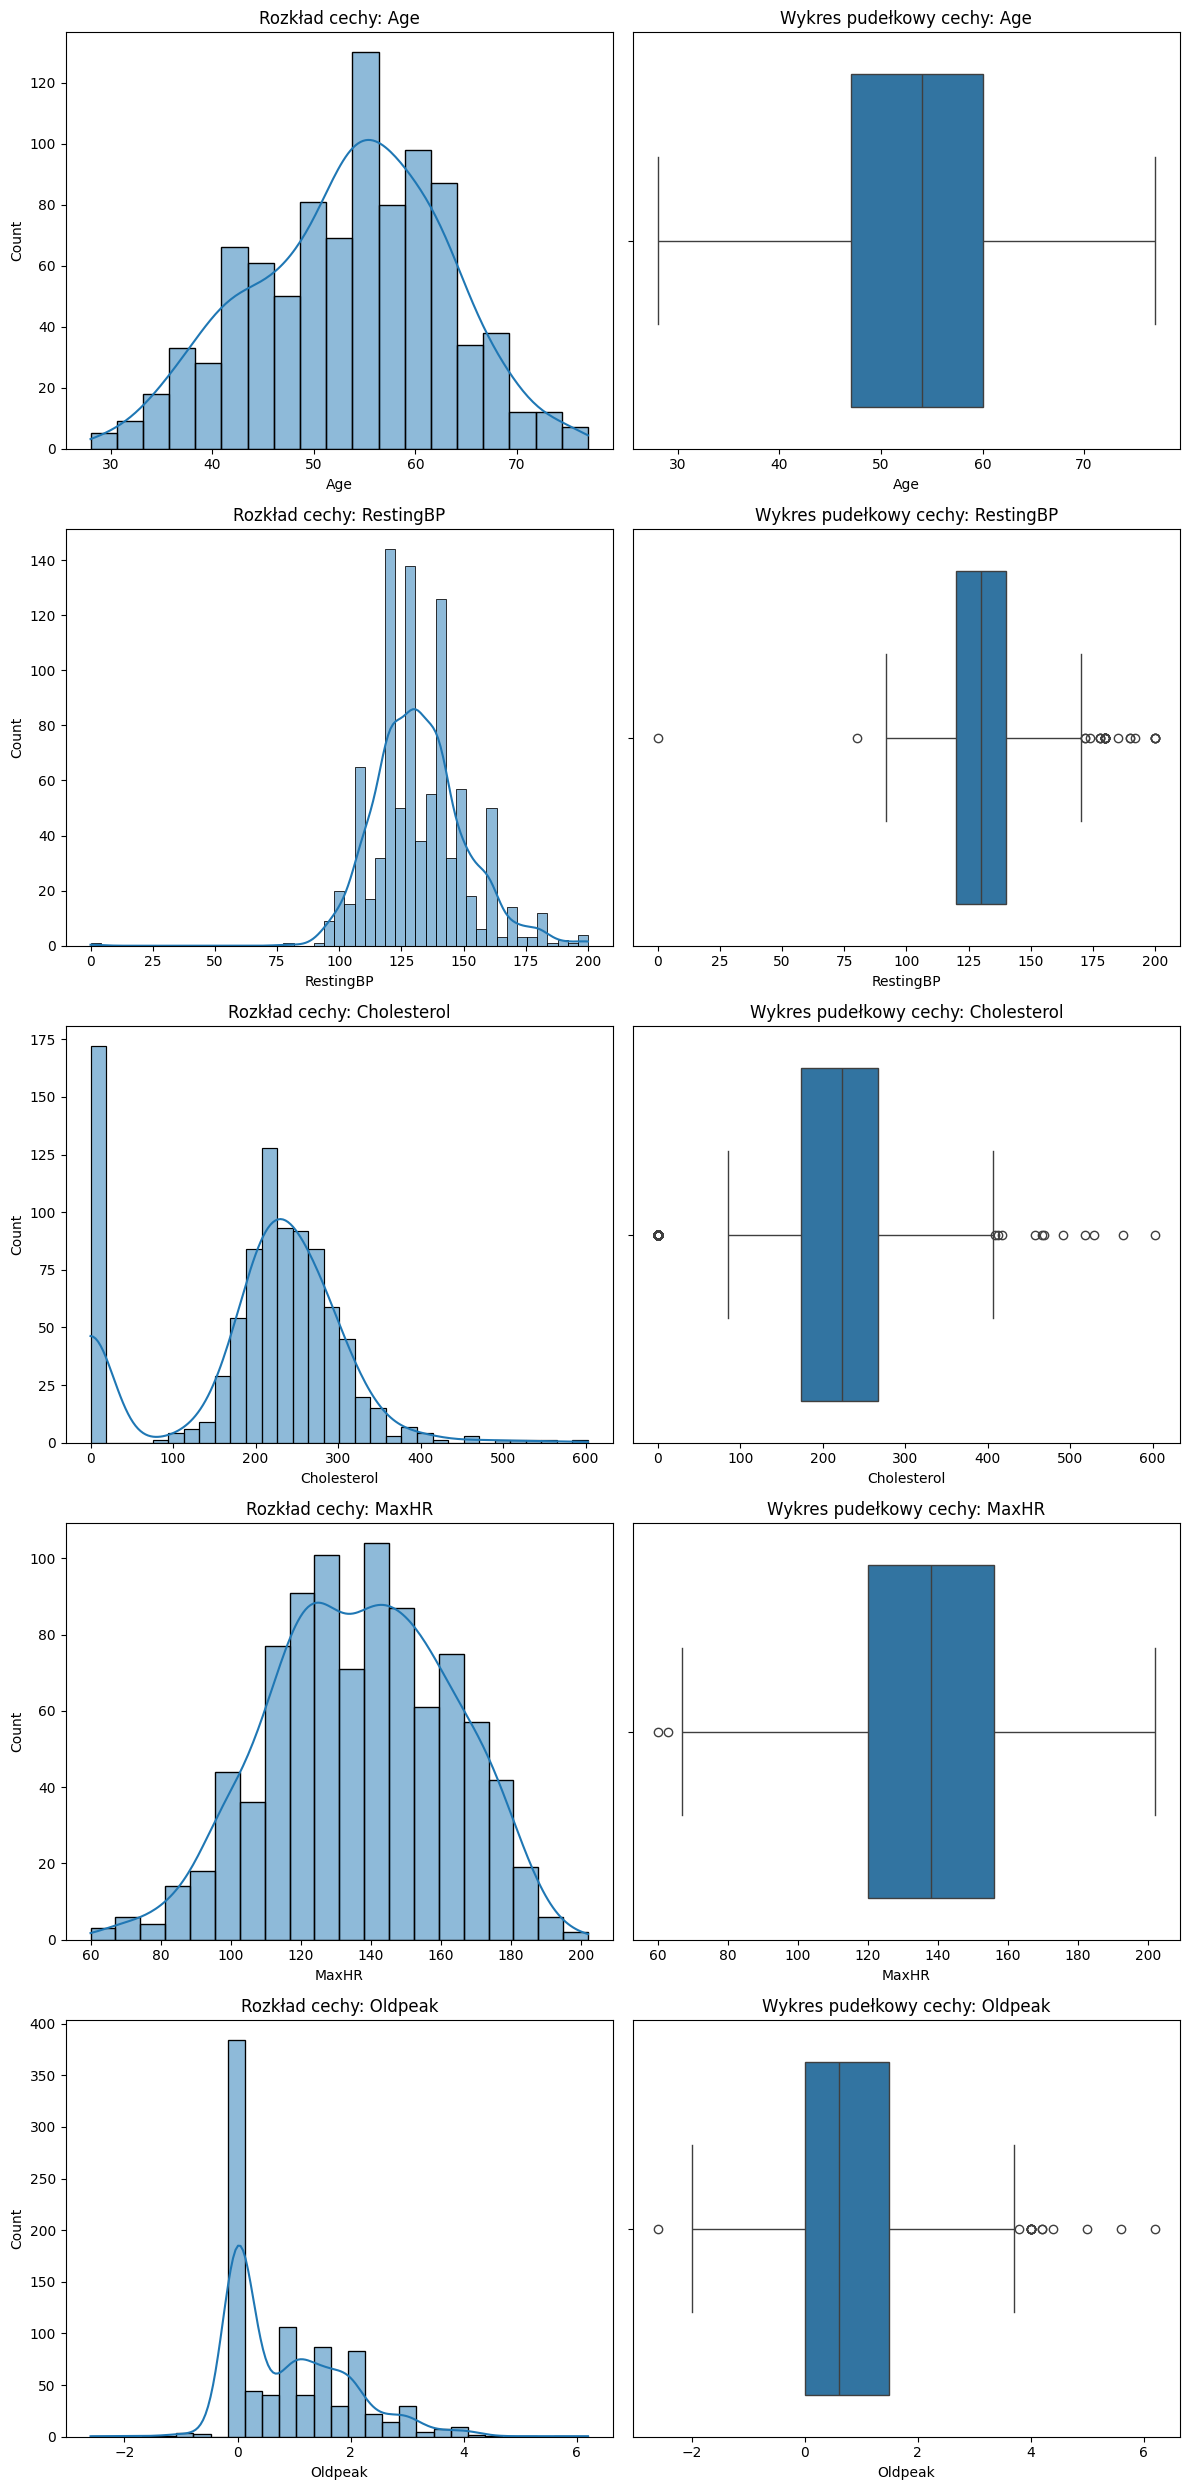

In [ ]:
# Ignorowanie ostrzeżeń
warnings.filterwarnings("ignore")

# Liczba zmiennych ciągłych
num_cont = len(cont_col)

# Tworzymy siatkę wykresów, która składa się z 2 kolumn (jeden wykres obok drugiego) i tyle wierszy, ile mamy zmiennych ciągłych
fig, axes = plt.subplots(nrows=num_cont, ncols=2, figsize=(12, 5 * num_cont))

# Jeśli mamy tylko jedną zmienną ciągłą, axes nie będzie macierzą 2D, więc zamieniamy go na listę:
if num_cont == 1:
    axes = [axes]

# Iterujemy po każdej zmiennej ciągłej
for i, column in enumerate(cont_col):
    # Lewy wykres: histogram z KDE (rozkład cechy)
    sns.histplot(data=df, x=column, kde=True, ax=axes[i][0])
    axes[i][0].set_title(f'Rozkład cechy: {column}')

    # Prawy wykres: wykres pudełkowy
    sns.boxplot(x=df[column], ax=axes[i][1])
    axes[i][1].set_title(f'Wykres pudełkowy cechy: {column}')

plt.tight_layout()
plt.show()


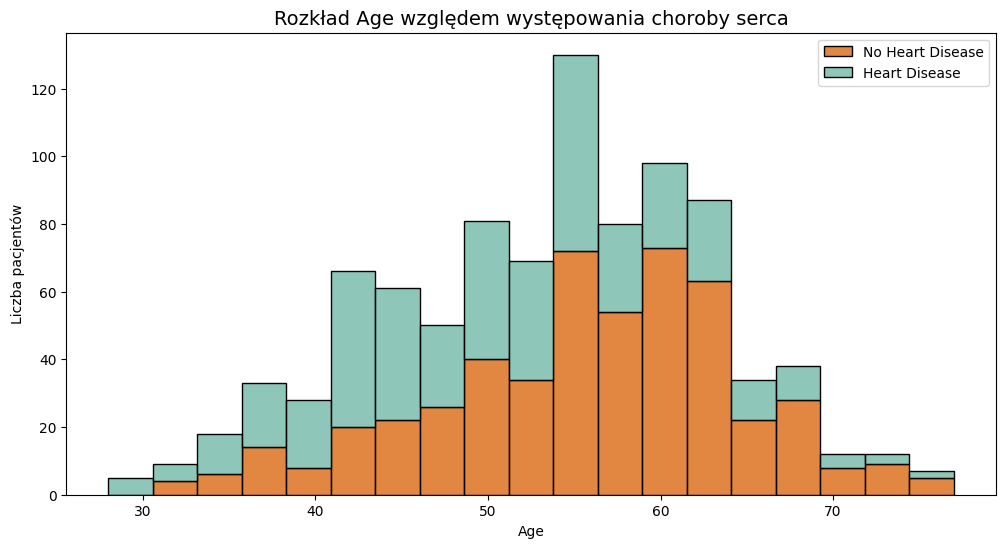

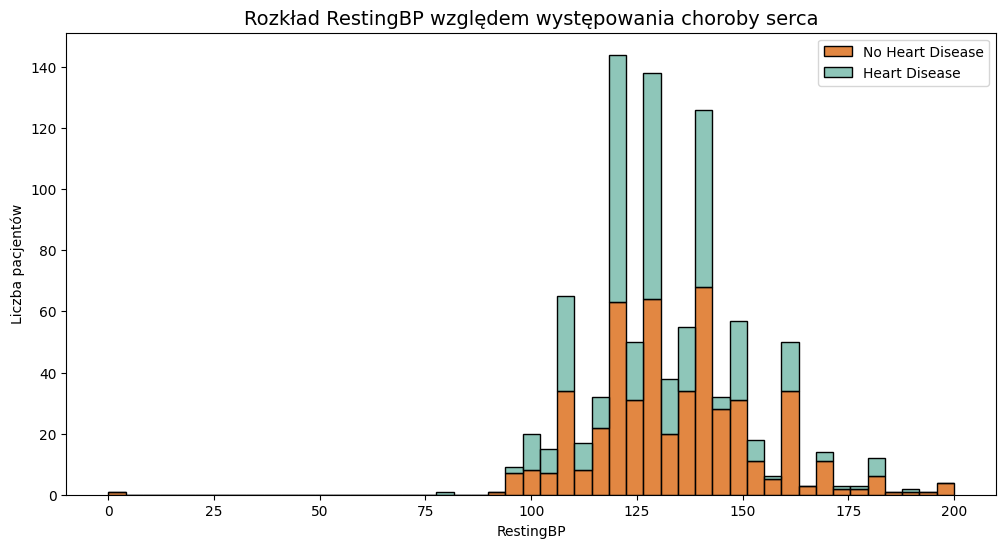

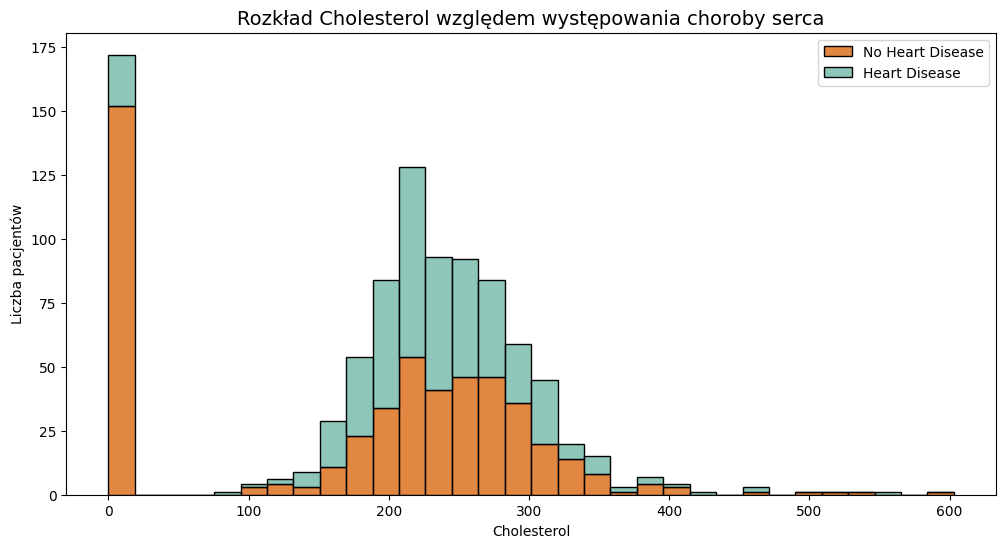

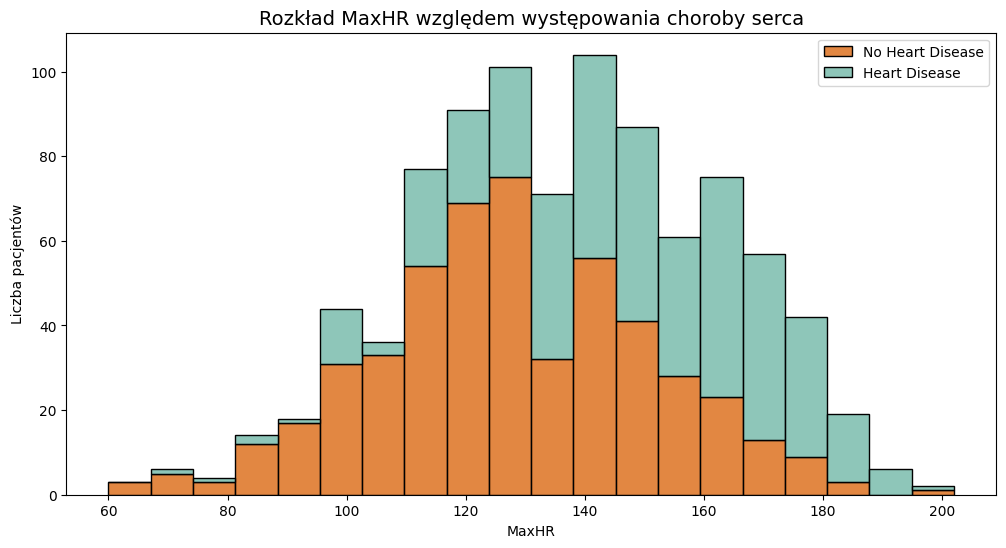

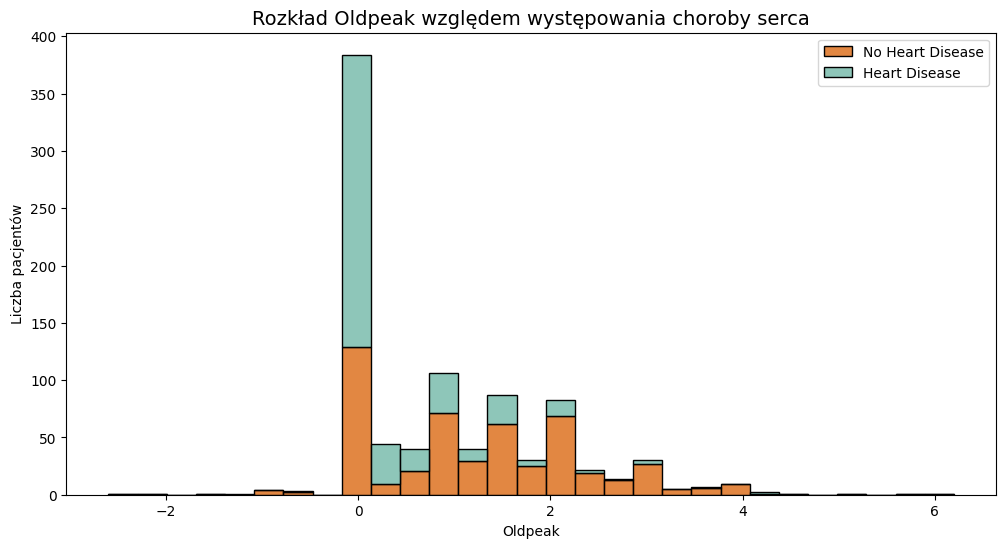

In [ ]:
for var in cont_col:
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=df,
        x=var,
        hue="HeartDisease",
        multiple="stack",
        palette=["#69b3a2", "#d95f02"],
        edgecolor="black",
        kde=False
    )
    plt.title(f'Rozkład {var} względem występowania choroby serca', fontsize=14)
    plt.xlabel(var)
    plt.legend(["No Heart Disease", "Heart Disease"])
    plt.ylabel("Liczba pacjentów")

Histogramy pokazują rozkład danych dla każdej cechy, podczas gdy wykresy pudełkowe wizualizują medianę, kwartyle oraz wartości odstające.

**Wnioski z wykresów**:
- **Age (Wiek)**: Rozkład zbliżony do normalnego, bez znaczących wartości odstających.
- **RestingBP (Spoczynkowe ciśnienie krwi)**: Prawdopodobnie błąd w danych (wartość 0), kilka wartości odstających powyżej 170 mmHg.
- **Cholesterol**: Niektóre wartości zerowe (prawdopodobnie brak danych), obecność wysokich wartości odstających powyżej 400 mg/dl.
- **MaxHR (Maksymalne tętno)**: Rozkład normalny, kilka niskich wartości odstających.
- **Oldpeak (Obniżenie odcinka ST)**: Skrajne wartości odstające, w tym ujemne wartości, które mogą wskazywać na błędy lub nietypowe pomiary.

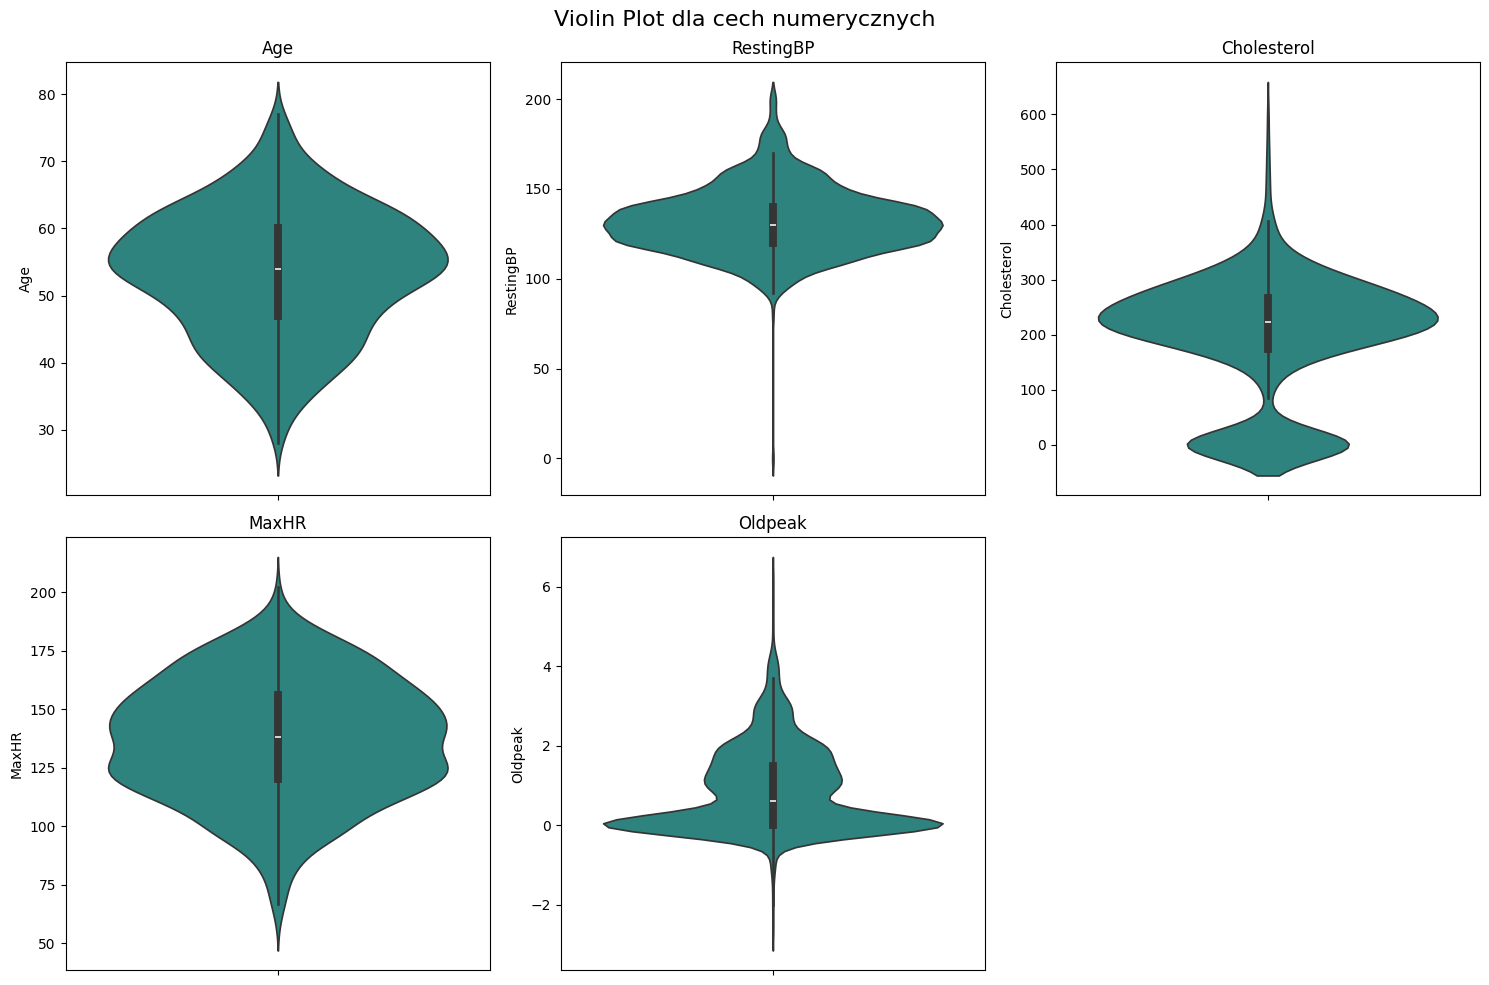

In [ ]:
warnings.filterwarnings("ignore")

# Ustawienie liczby kolumn i wierszy
cols = 3
rows = math.ceil(len(cont_col) / cols)

# Tworzenie sublotów
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
fig.suptitle("Violin Plot dla cech numerycznych", fontsize=16)

# Równomierne rozmieszczenie wykresów
axes = axes.flatten()

for i, col in enumerate(cont_col):
    sns.violinplot(y=df[col], ax=axes[i], palette="viridis")
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel("")  # Usunięcie etykiety osi X dla czytelności

# Usunięcie pustych wykresów, jeśli liczba kolumn nie jest podzielna przez 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Poprawienie rozmieszczenia
plt.show()


Wykresy skrzypcowe (violin plots) przedstawiają rozkład wartości dla każdej zmiennej, łącząc informacje z histogramu i wykresu pudełkowego, co pozwala lepiej zobaczyć gęstość rozkładu danych.

**Wnioski z wykresów:**
- **Age (Wiek)**: Rozkład symetryczny, skupiony wokół 50-60 lat.
- **RestingBP (Spoczynkowe ciśnienie krwi)**: Większość wartości mieści się między 110-140 mmHg.
- **Cholesterol**: Dwa wyraźne skupiska – jedno blisko **0** (prawdopodobnie to błąd), drugie w zakresie 150-300 mg/dl. Występują wartości odstające powyżej 400 mg/dl.
- **MaxHR (Maksymalne tętno)**: Rozkład zbliżony do normalnego, większość danych mieści się między 100-175 bpm, z kilkoma wartościami odstającymi poniżej 80 bpm.
- **Oldpeak (Obniżenie odcinka ST)**: Widoczne wartości ujemne. Większość danych mieści się w przedziale 0-2.


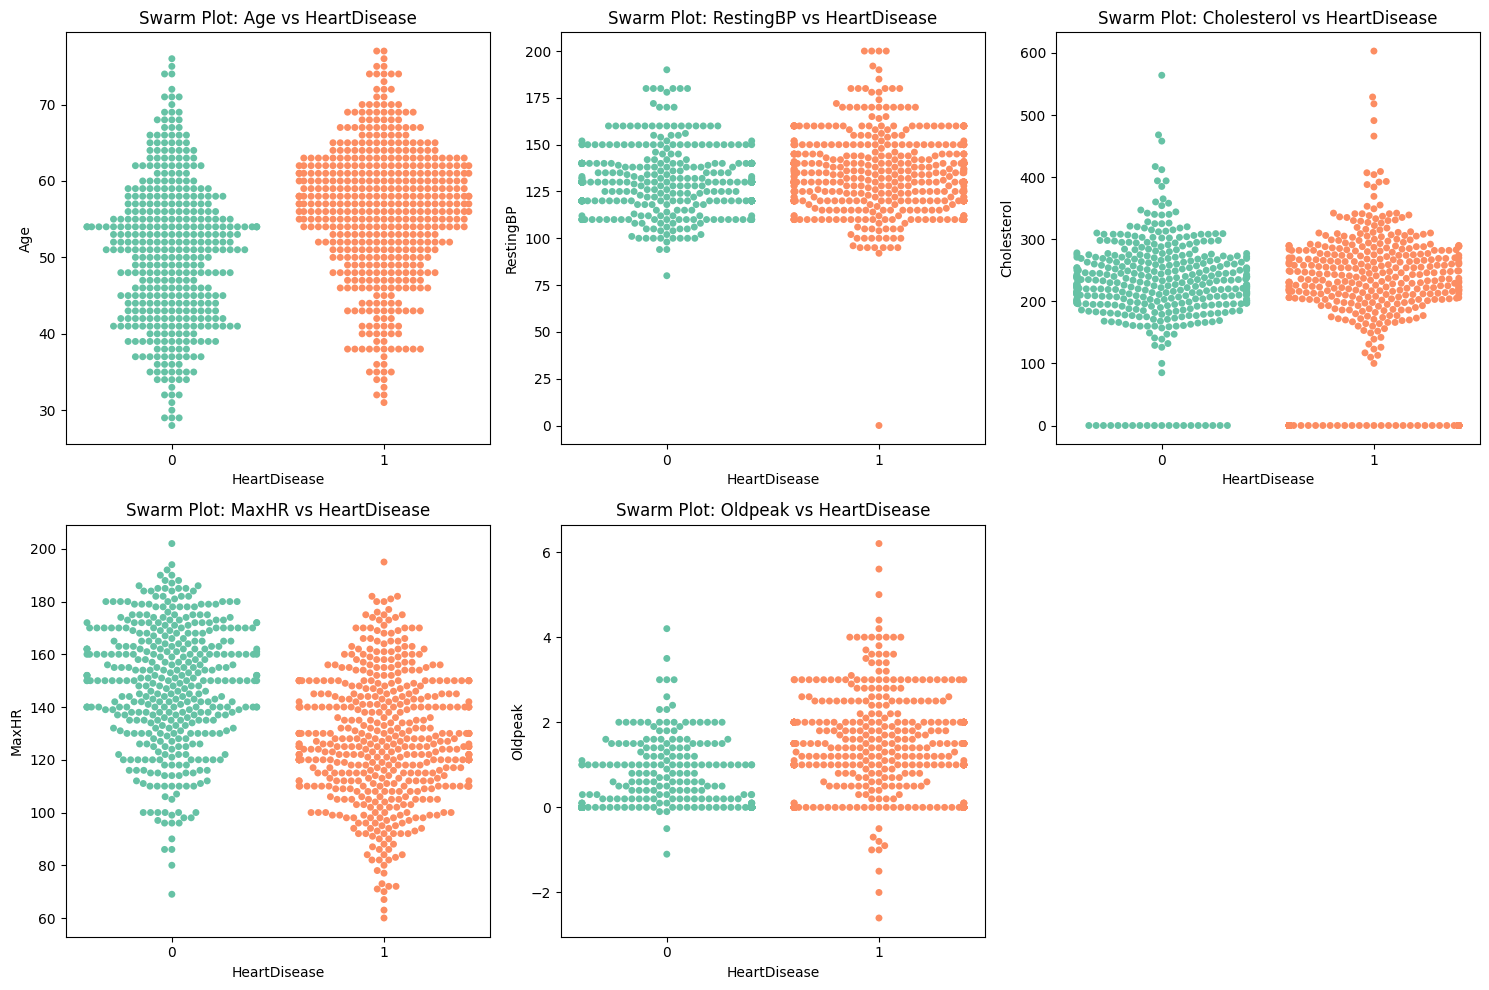

In [ ]:
warnings.filterwarnings("ignore")

# Ustal liczbę kolumn i oblicz liczbę wierszy
cols = 3
rows = math.ceil(len(cont_col) / cols)

# Tworzymy siatkę wykresów
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()  # Spłaszczamy tablicę osi

# Iterujemy przez cechy i rysujemy wykres swarm plot dla każdej z nich
for i, feature in enumerate(cont_col):
    ax = axes[i]
    sns.swarmplot(x="HeartDisease", y=feature, data=df, palette="Set2", ax=ax)
    ax.set_title(f"Swarm Plot: {feature} vs HeartDisease")
    ax.set_xlabel("HeartDisease")
    ax.set_ylabel(feature)

# Ukrycie ewentualnych pustych subplotów
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Wykresy roju (swarm plot) przedstawiają zależność między cechami numerycznymi a obecnością choroby serca (HeartDisease). Każdy punkt reprezentuje pojedynczą obserwację, a rozmieszczenie punktów pokazuje różnice w wartościach cech dla osób zdrowych (0) i chorych (1).

**Wnioski z wykresów:**
- **Age (Wiek)**: Osoby z chorobą serca są zazwyczaj starsze, co sugeruje większe ryzyko choroby w wyższych grupach wiekowych.
- **RestingBP (Spoczynkowe ciśnienie krwi)**: U osób z chorobą serca ciśnienie wydaje się być nieco wyższe.
- **Cholesterol**: Widoczne wartości **0**, co może oznaczać brak pomiarów. Nie widać dużych różnic między grupami, ale wartości odstające są częstsze u chorych.
- **MaxHR (Maksymalne tętno)**: Osoby z chorobą serca mają niższe tętno maksymalne, co może wskazywać na problemy z wydolnością serca.
- **Oldpeak (Obniżenie odcinka ST)**: Wyższe wartości Oldpeak występują częściej u osób z chorobą serca, co sugeruje większe niedokrwienie serca.


##zmienne kategoryczne

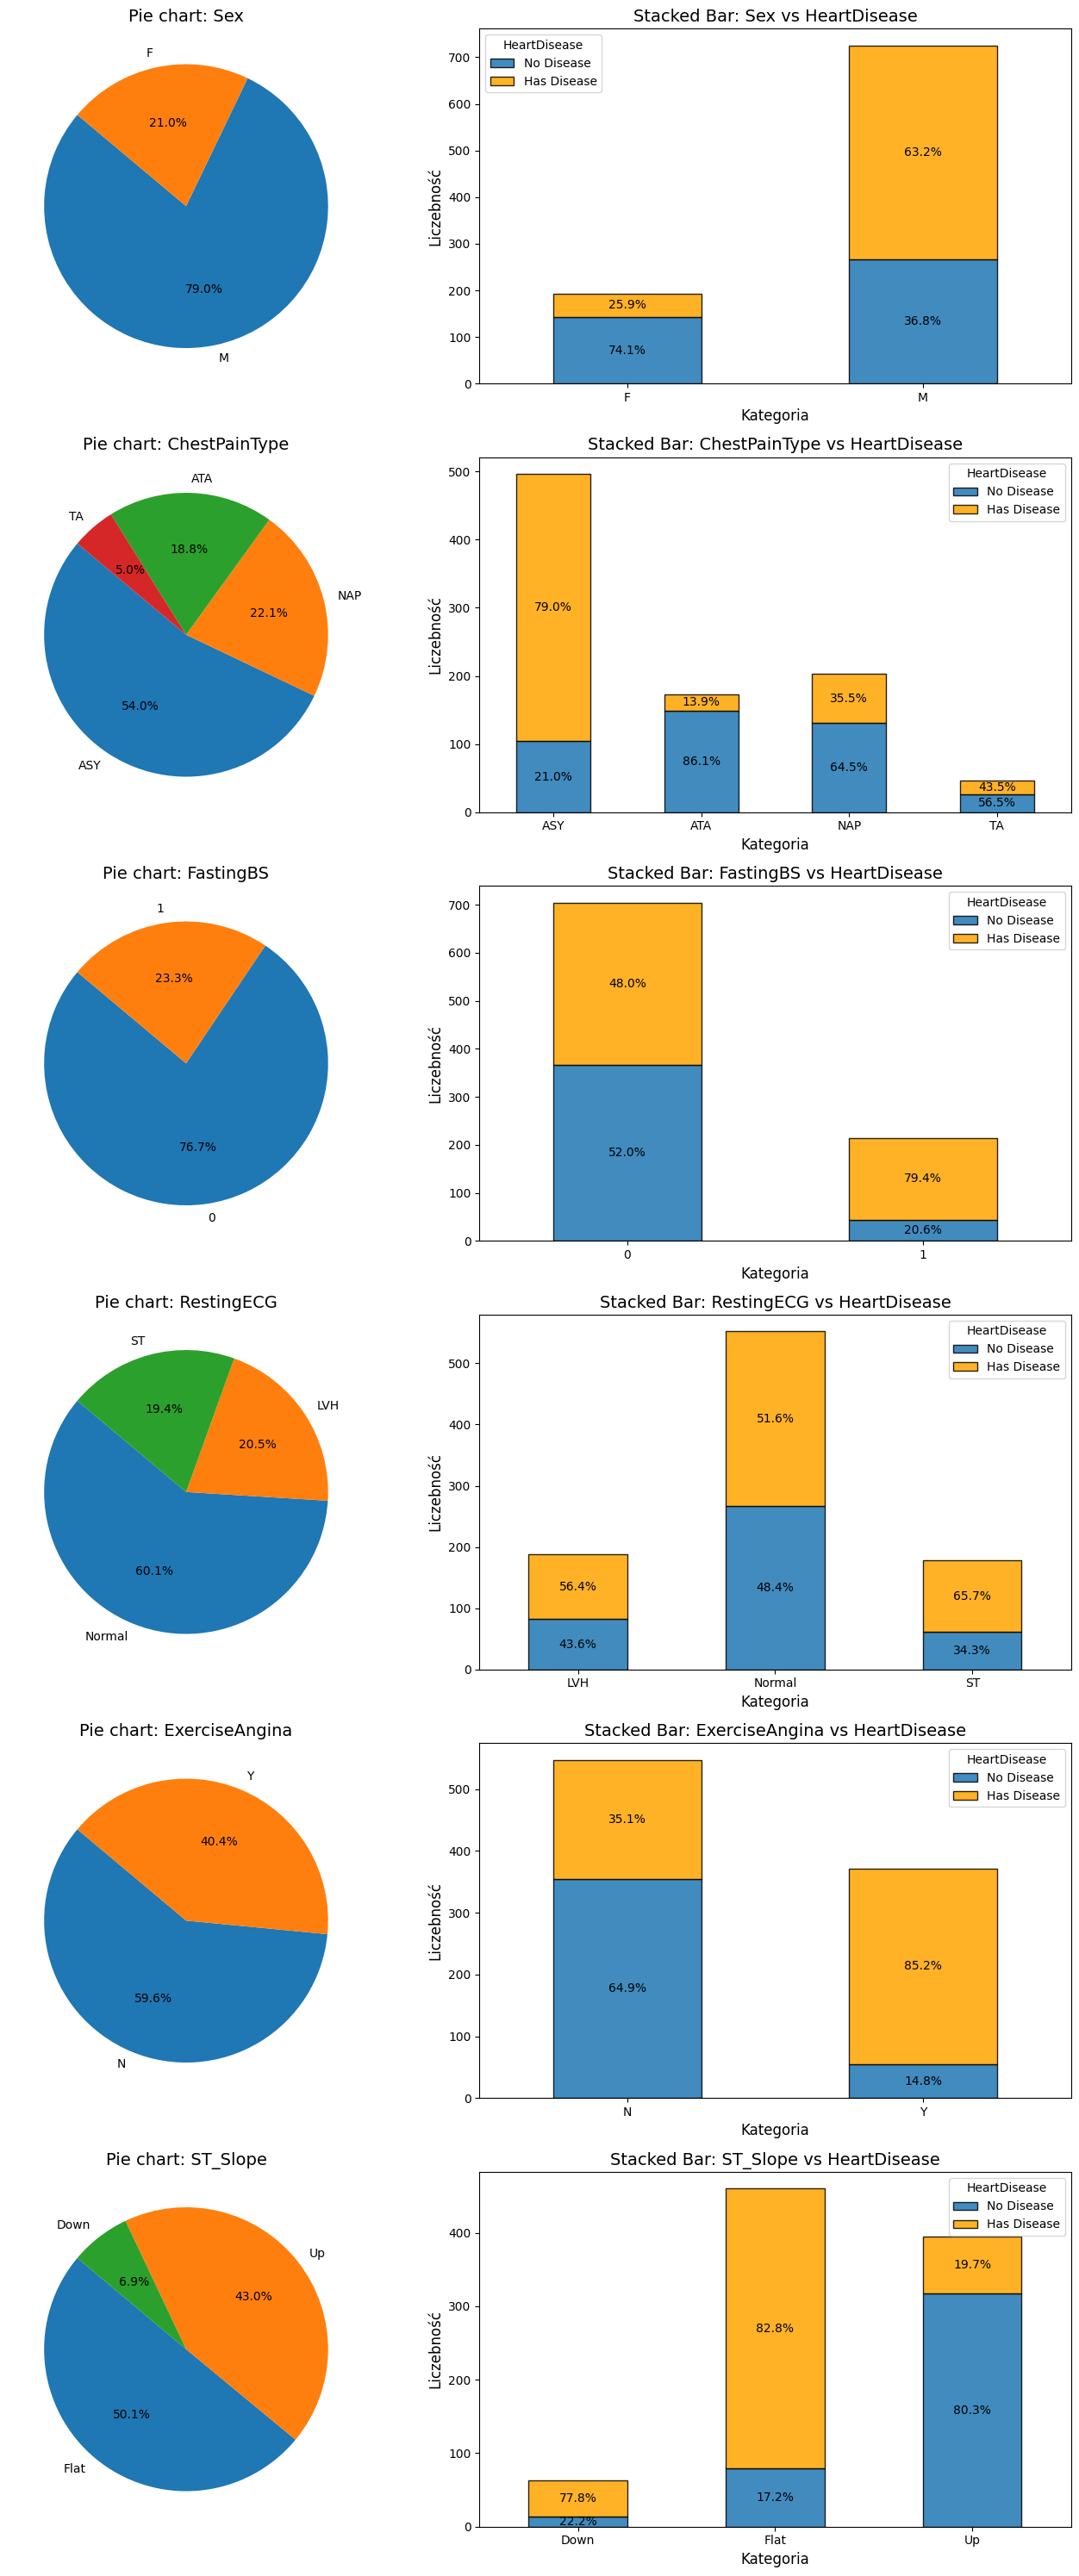

In [ ]:
import matplotlib.pyplot as plt


def stacked_barchart(data, ax, title='', ylabel=''):
    """
    Funkcja pomocnicza do rysowania wykresu słupkowego skumulowanego z procentami

    Args:
        data (DataFrame): Dane do wykresu (indeks – kategorie, kolumny – segmenty).
        ax (matplotlib.axes.Axes): Oś.
        title (str): Tytuł wykresu.
        ylabel (str): Etykieta osi Y.
    """
    # Tworzymy wykres słupkowy skumulowany, ustawiając kolory, przezroczystość i krawędzie słupków
    data.plot(kind='bar', stacked=True,
              color=['#1f77b4', '#ffa500'],  # Ustawienie kolorów słupków
              alpha=0.85, edgecolor='black', ax=ax)

    # Dodanie tytułu wykresu oraz etykiet osi X i Y
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('Kategoria', fontsize=12)

    # Ustawienie parametrów osi X i Y (rozmiar czcionki, rotacja etykiet)
    ax.tick_params(axis='x', labelrotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Dodanie legendy z tytułem "HeartDisease"
    ax.legend(title="HeartDisease", fontsize=10)

    # Dodawanie procentowych etykiet do każdego segmentu słupków
    for i, index in enumerate(data.index):  # Iterujemy po indeksach (kategoriach) w DataFrame
        total = data.loc[index].sum()  # Suma wartości dla danej kategorii (całkowita wysokość słupka)
        cum_value = 0  # Inicjalizujemy wartość skumulowaną, która pomoże w umieszczaniu tekstu

        for col in data.columns:  # Iterujemy po kolumnach (segmentach słupków)
            value = data.loc[index, col]  # Pobieramy wartość danego segmentu

            # Obliczamy procentowy udział segmentu w całkowitej wysokości słupka
            percent = (value / total * 100) if total > 0 else 0

            # Dodajemy etykietę tylko jeśli wartość segmentu jest większa od 0
            if value > 0:
                ax.text(i, cum_value + value / 2, f'{percent:.1f}%',  # Tekst wyśrodkowany w segmencie
                        ha='center', va='center', fontsize=10)
            cum_value += value  # Aktualizacja wartości skumulowanej dla następnego segmentu

# Przygotowanie listy zmiennych kategorycznych (pomijając kolumnę 'HeartDisease')
cat_features = [feature for feature in cat_col if feature != 'HeartDisease']

# Liczba zmiennych kategorycznych, które analizujemy (określa liczbę wierszy w wykresach)
num_features = len(cat_features)

# Tworzymy siatkę wykresów (po 2 w każdym wierszu: wykres kołowy i słupkowy skumulowany)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, 5 * num_features))

# Obsługa przypadku, gdy mamy tylko jedną cechę - wtedy axes nie jest macierzą 2D, więc robimy listę
if num_features == 1:
    axes = [axes]

# Iterujemy po każdej zmiennej kategorycznej
for i, feature in enumerate(cat_features):
    # Obsługa indeksowania osi - dla jednego wiersza axes to lista, dla wielu to macierz 2D
    if num_features == 1:
        ax_pie = axes[0]  # Pierwszy wykres (pie chart)
        ax_bar = axes[1]  # Drugi wykres (stacked bar chart)
    else:
        ax_pie = axes[i, 0]  # Pierwsza kolumna - wykres kołowy
        ax_bar = axes[i, 1]  # Druga kolumna - wykres słupkowy

    # === Wykres kołowy (pie chart) dla rozkładu cechy ===
    value_counts = df[feature].value_counts()  # Liczba wystąpień każdej kategorii w kolumnie
    ax_pie.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    ax_pie.set_title(f'Pie chart: {feature}', fontsize=14)

    # === Wykres słupkowy skumulowany (stacked bar chart) ===
    # Grupowanie danych wg cechy oraz zmiennej HeartDisease (0/1) i zliczanie liczności
    temp = df[[feature, 'HeartDisease']].groupby([feature, 'HeartDisease']).size().unstack('HeartDisease', fill_value=0)

    # Zmiana nazw kolumn dla lepszej czytelności (zakładamy, że wartości HeartDisease to 0 i 1)
    temp.rename(columns={0: 'No Disease', 1: 'Has Disease'}, inplace=True)

    # Wywołanie funkcji do rysowania wykresu słupkowego skumulowanego
    stacked_barchart(temp, ax=ax_bar, title=f'Stacked Bar: {feature} vs HeartDisease', ylabel='Liczebność')

# Optymalizacja układu wykresów, aby nie nachodziły na siebie
plt.tight_layout()
plt.show()


Wykresy kołowe (pie charts) przedstawiają procentowy udział poszczególnych kategorii cech kategorycznych, natomiast skumulowane wykresy słupkowe (stacked bar charts) pokazują podział tych cech w zależności od obecności choroby serca (HeartDisease).

**Wnioski z wykresów:**
- **Sex (Płeć)**: Większość pacjentów to mężczyźni (79%). Choroba serca częściej występuje u mężczyzn (63,2% vs. 36,8% u kobiet).
- **ChestPainType (Rodzaj bólu w klatce piersiowej)**: Najczęstszy typ to **ASY (bezobjawowy)** (54%), co wskazuje na częste przypadki bez charakterystycznych objawów. Pacjenci z typowym bólem dławicowym (TA) mają mniejsze ryzyko choroby serca niż ci bezobjawowi.
- **FastingBS (Cukier na czczo)**: 23,3% pacjentów ma podwyższony poziom glukozy na czczo (>120 mg/dl), a w tej grupie choroba serca występuje znacznie częściej (79,4%).
- **RestingECG (EKG spoczynkowe)**: 60,1% pacjentów ma prawidłowy zapis EKG, ale pacjenci z nieprawidłowym ST (19,4%) częściej mają chorobę serca (65,7% przypadków).
- **ExerciseAngina (Dławica wysiłkowa)**: 40,4% pacjentów doświadcza bólu w klatce piersiowej podczas wysiłku – w tej grupie 85,2% ma chorobę serca.
- **ST_Slope (Nachylenie odcinka ST)**: Pacjenci z opadającym ST (6,9%) mają bardzo wysokie ryzyko choroby serca (77,8%), natomiast ci z wznoszącym ST (43%) rzadziej chorują (80,3% zdrowych).

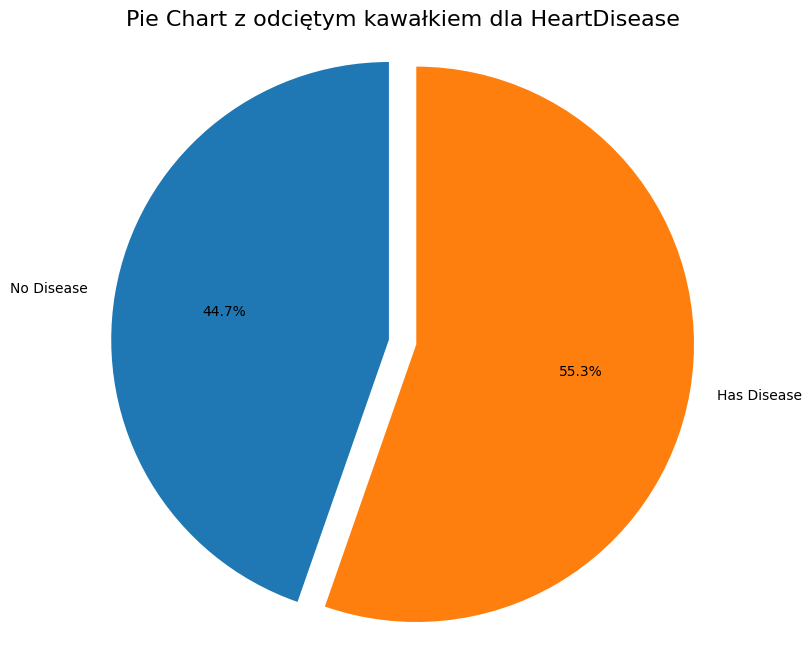

In [ ]:
import matplotlib.pyplot as plt

# Przygotowanie danych: zakładamy, że kolumna 'HeartDisease' zawiera wartości 0 i 1
heart_counts = df['HeartDisease'].value_counts().sort_index()
labels = ['No Disease', 'Has Disease']
sizes = heart_counts.values

# Ustawienie parametru explode: oddzielamy kawałek dla 'Has Disease'
explode = (0, 0.1)  # 0 dla pierwszego kawałka, 0.1 dla drugiego (odstęp od środka)

# Rysowanie wykresu kołowego z oddzielonym kawałkiem
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode)
plt.axis('equal')  # Zapewnia, że koło będzie okrągłe
plt.title('Pie Chart z odciętym kawałkiem dla HeartDisease', fontsize=16)
plt.show()


Wykres kołowy przedstawia podział klas w etykiecie **HeartDisease** – **55.3% pacjentów ma chorobę serca**, a **44.7% jest zdrowych**.  

**Wnioski**:
 **Dobrze zbilansowany zbiór danych** – różnica między klasami nie jest znacząca.  
**Nie ma potrzeby stosowania metod balansowania** (np. **SMOTE, Tomek Links**)

## Rozkład wyników w poszczególnych cechach

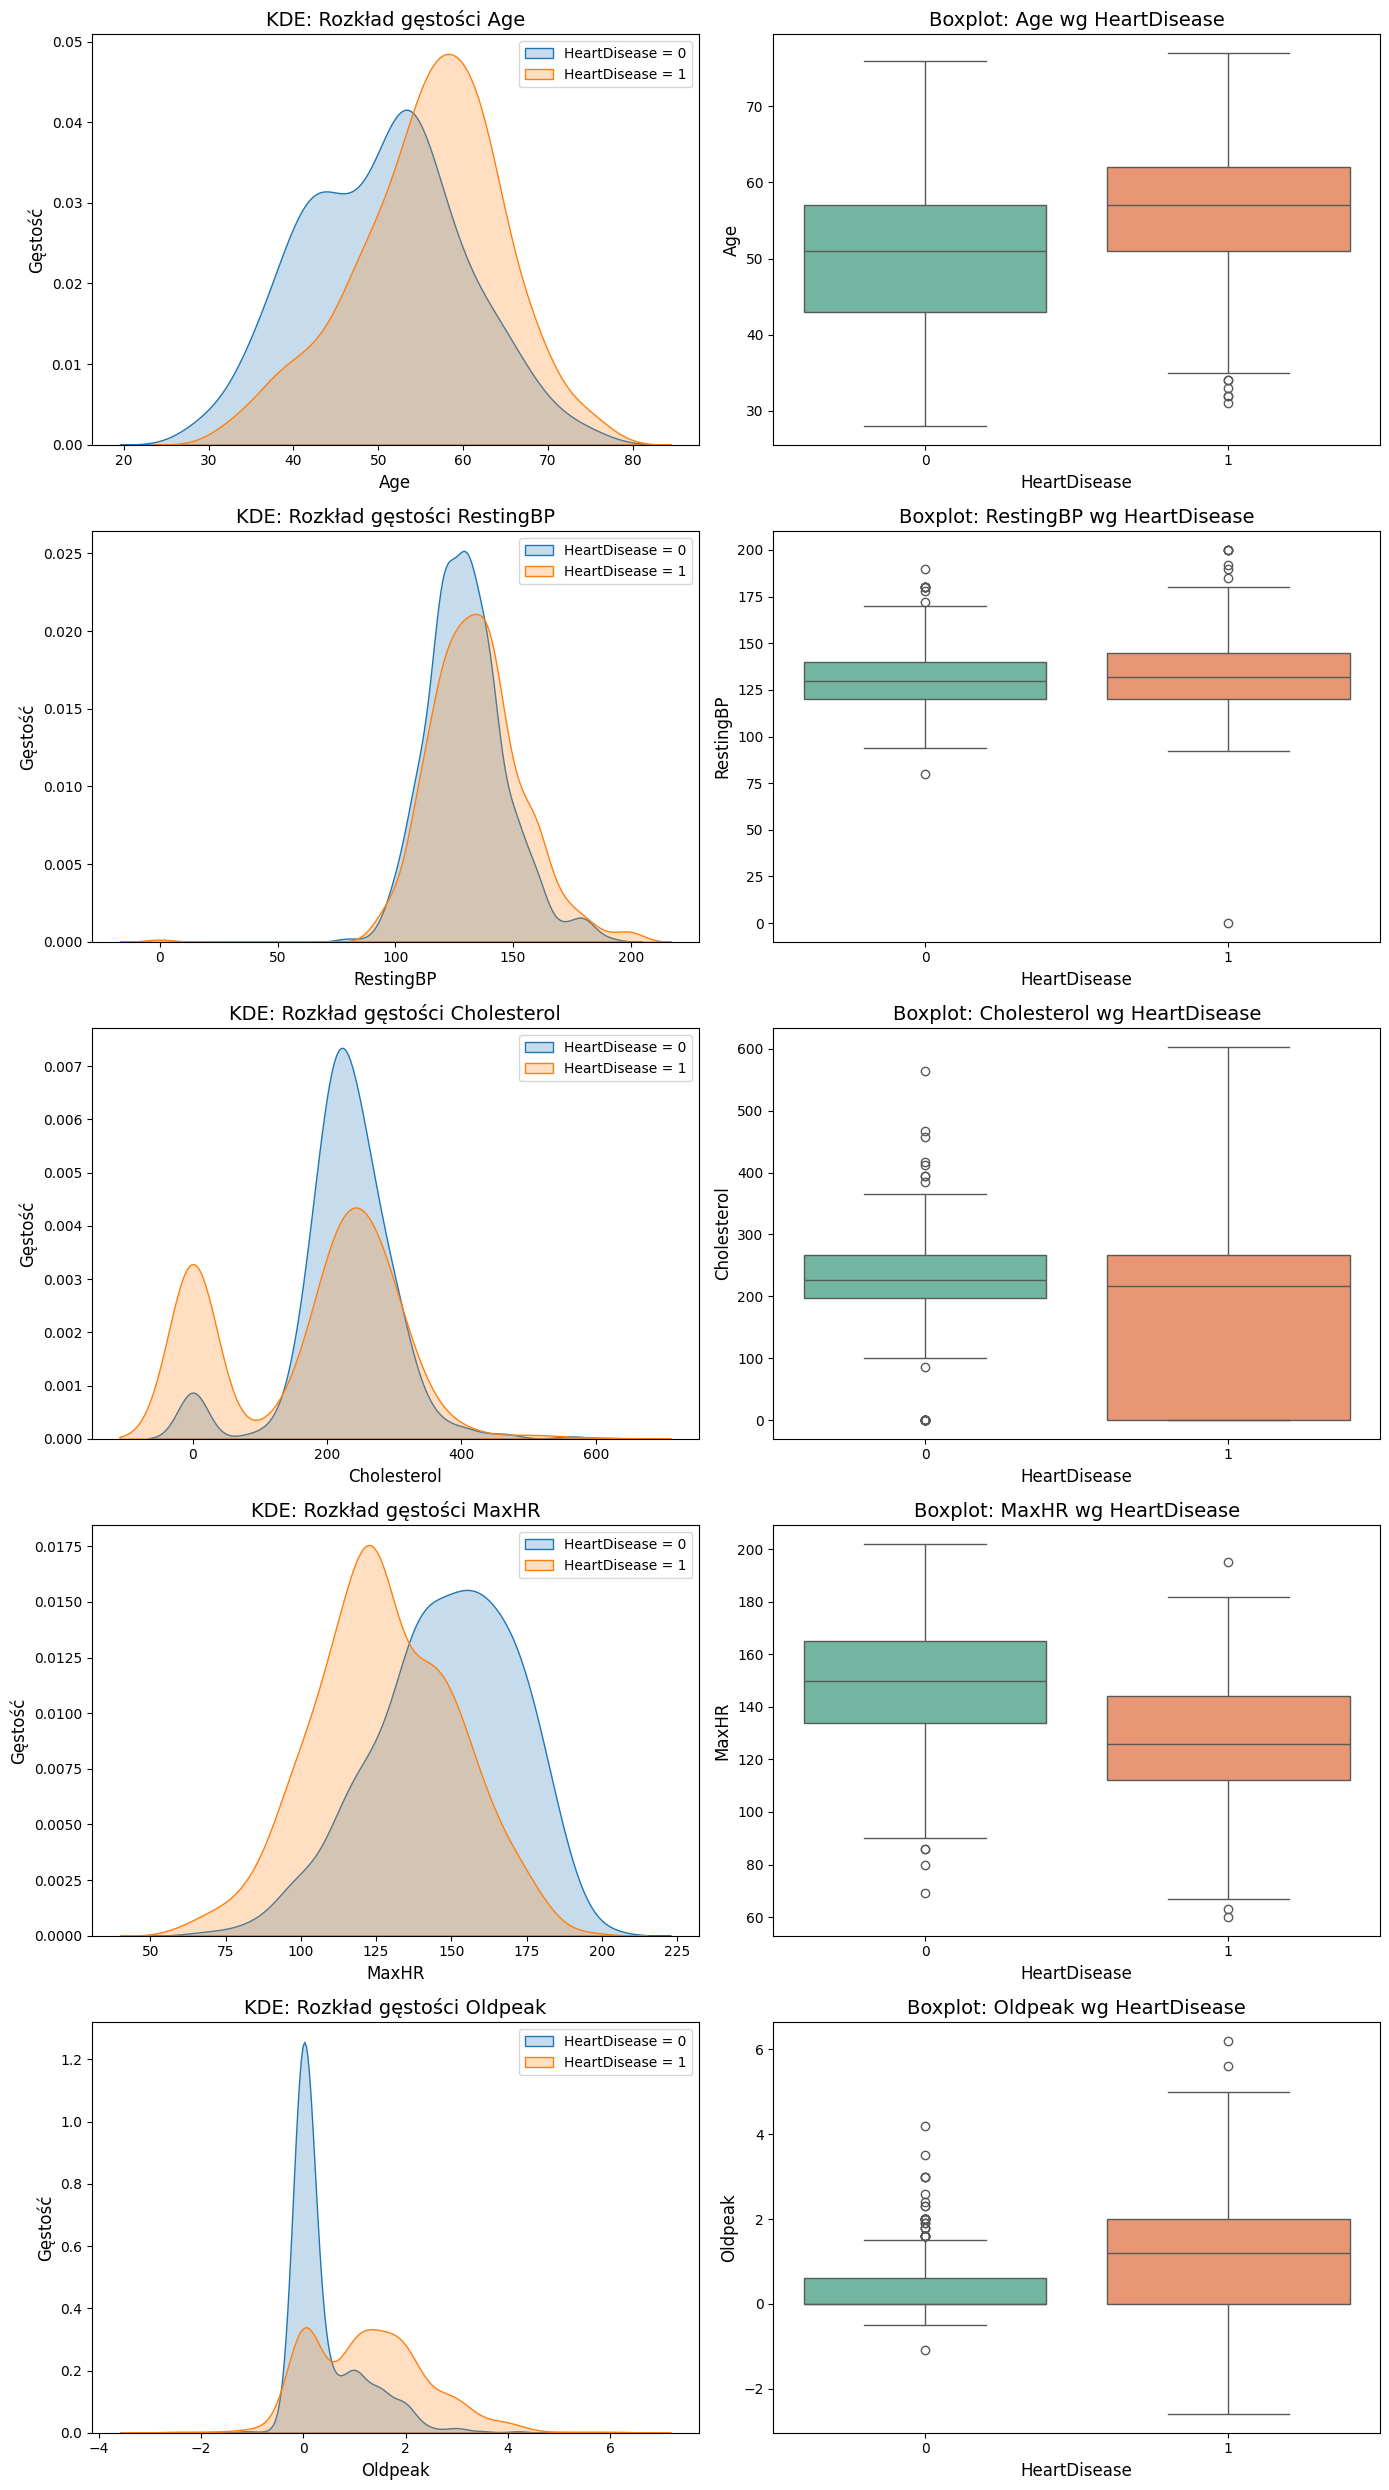

In [ ]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # używamy do ewentualnej modyfikacji wymiaru axes przy jednej cesze

# Ignorowanie ostrzeżeń (opcjonalne)
warnings.filterwarnings("ignore")
# Lista cech ciągłych oraz zmienna docelowa
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
target = 'HeartDisease'

num_features = len(features)

# Tworzymy siatkę wykresów: dla każdej cechy jeden wiersz, 2 kolumny (lewa: KDE, prawa: Boxplot)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(14, 5 * num_features))

# Jeśli analizujemy tylko jedną cechę, upewnijmy się, że axes jest 2D (o wymiarach 1x2)
if num_features == 1:
    axes = np.array([axes])

for i, feature in enumerate(features):
    # --- Lewy wykres: KDE ---
    ax_kde = axes[i, 0]

    # Rysujemy rozkład gęstości osobno dla grup: HeartDisease = 0 i HeartDisease = 1
    sns.kdeplot(data=df[df[target] == 0], x=feature, fill=True, label=f'{target} = 0', ax=ax_kde)
    sns.kdeplot(data=df[df[target] == 1], x=feature, fill=True, label=f'{target} = 1', ax=ax_kde)

    # Ustawienia osi i tytułu dla wykresu KDE
    ax_kde.set_title(f'KDE: Rozkład gęstości {feature}', fontsize=14)
    ax_kde.set_xlabel(feature, fontsize=12)
    ax_kde.set_ylabel('Gęstość', fontsize=12)
    ax_kde.legend(fontsize=10)

    # --- Prawy wykres: Boxplot ---
    ax_box = axes[i, 1]

    # Rysujemy wykres pudełkowy, gdzie na osi X mamy zmienną docelową, a na osi Y daną cechę
    sns.boxplot(data=df, x=target, y=feature, ax=ax_box, palette='Set2')

    # Ustawienia osi i tytułu dla wykresu Boxplot
    ax_box.set_title(f'Boxplot: {feature} wg {target}', fontsize=14)
    ax_box.set_xlabel(target, fontsize=12)
    ax_box.set_ylabel(feature, fontsize=12)

plt.tight_layout()
plt.show()


Wykresy KDE (Kernel Density Estimation) przedstawiają rozkład gęstości cech numerycznych w podziale na osoby z chorobą serca (HeartDisease = 1) i bez choroby (HeartDisease = 0), a wykresy pudełkowe (boxplot) pokazują medianę, kwartyle i wartości odstające dla tych grup.

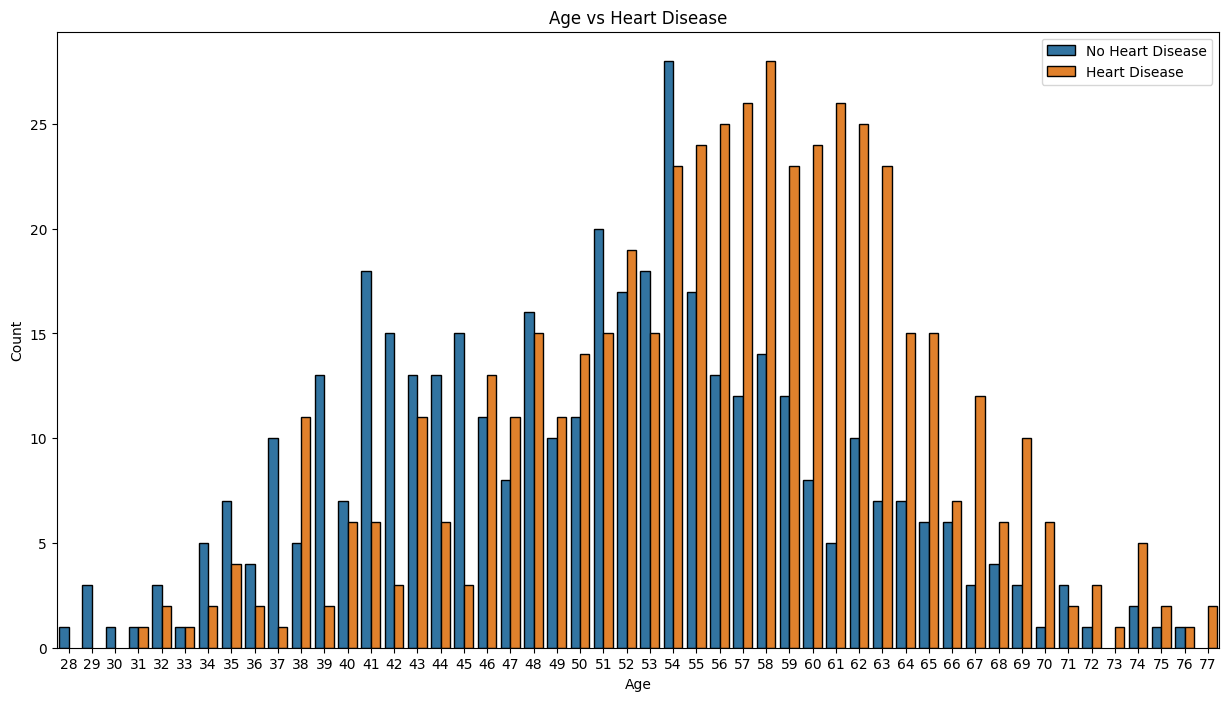

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tworzymy wykres countplot dla "Age" vs "HeartDisease"
plt.figure(figsize=(15,8))
sns.countplot(x="Age", data=df, hue="HeartDisease", edgecolor="black")

# Ustawienia wykresu
plt.legend(["No Heart Disease", "Heart Disease"])
plt.title("Age vs Heart Disease")
plt.xlabel("Age")
plt.ylabel("Count")

# Wyświetlenie wykresu
plt.show()


Wykres słupkowy przedstawia rozkład wieku pacjentów w podziale na osoby z chorobą serca (**Heart Disease**) oraz bez niej (**No Heart Disease**).

**Wnioski z wykresu:**
- W młodszych grupach wiekowych (poniżej 50 lat) więcej osób **nie ma choroby serca**, ale z wiekiem liczba przypadków choroby wzrasta.

##Macierz wykresów rozrzutu dla wszystkich par cech ciągłych wraz z histogramami lub wykresami KDE na przekątnej.

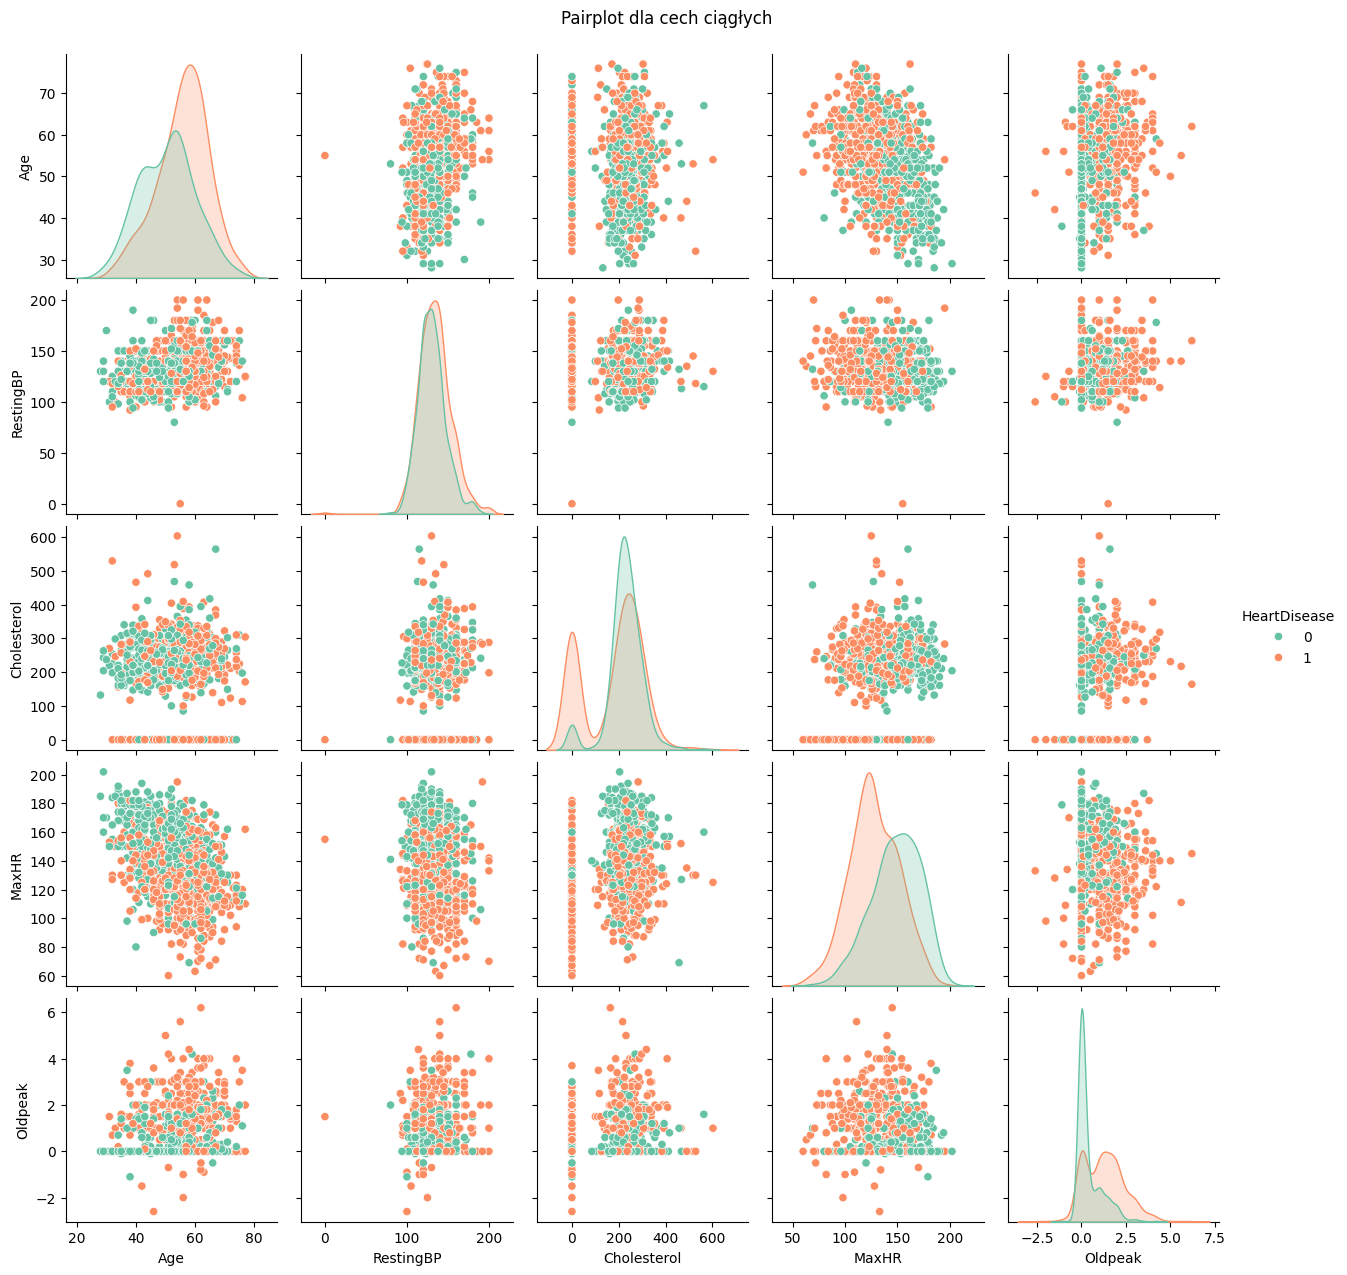

In [ ]:
sns.pairplot(df[features + [target]], hue=target, palette='Set2')
plt.suptitle('Pairplot dla cech ciągłych', y=1.02)
plt.show()

Pairplot przedstawia zależności między cechami numerycznymi w podziale na pacjentów z chorobą serca (HeartDisease = 1) i bez niej (HeartDisease = 0). Wykresy na przekątnej to rozkłady gęstości KDE dla poszczególnych cech.

##przetwarzanie zmiennych kategorycznych aby wyświetlić macierz korelacji

In [ ]:
# 📌 Tymczasowa kopia danych z zakodowanymi zmiennymi kategorycznymi
df_numeric = pd.get_dummies(df, drop_first=True)
df_numeric.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0   True               True              False             False   
1  False              False               True             False   
2   True               True              False             False   
3  False              False              False             False   
4   True              False               True             False   

   RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0               True          False             False          False   
1               True          False             False           True   
2              False           True             False          False   
3               True          False              True           True   
4               True          False             False          False   

   ST_Slope_Up  
0         True  
1        False  
2         True  
3        False  
4         True

### Maciesz Korelacji między cechami

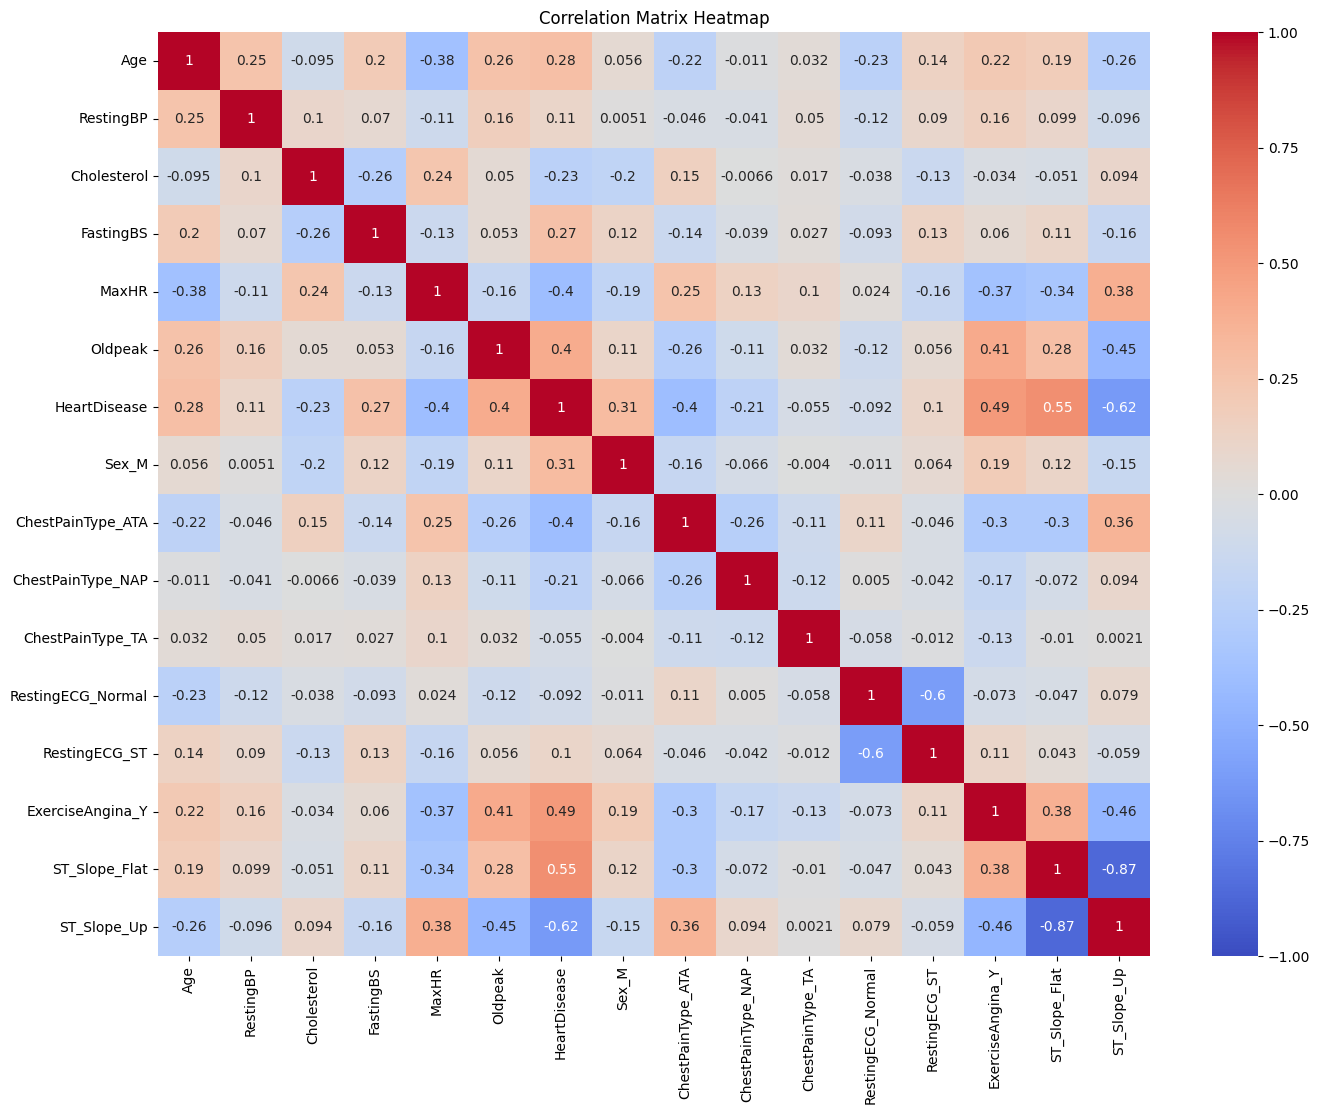

In [ ]:
plt.figure(figsize=(16, 12))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Najważniejsze wnioski z macierzy korelacji:**
- **HeartDisease**:
  - Najsilniejsze korelacje:
    - **MaxHR (-0.40)** → niższe maksymalne tętno związane z chorobą serca.
    - **Oldpeak (0.41)** → wyższe wartości wskazują na większe ryzyko choroby.
    - **ST_Slope_Flat (0.55)** → płaski odcinek ST częściej występuje u osób z chorobą.
    - **ST_Slope_Up (-0.62)** → wznoszący odcinek ST częściej u osób zdrowych.
    - **ExerciseAngina_Y (0.41)** → dławica wysiłkowa silnie powiązana z chorobą.

- **Pozostałe zależności**:
  - **Age vs. HeartDisease (0.28)** → wiek umiarkowanie powiązany z chorobą.
  - **MaxHR i Age (-0.38)** → starsze osoby mają niższe tętno maksymalne.
  - **Cholesterol i HeartDisease (-0.23)** → niska korelacja, cholesterol nie jest głównym czynnikiem ryzyka.


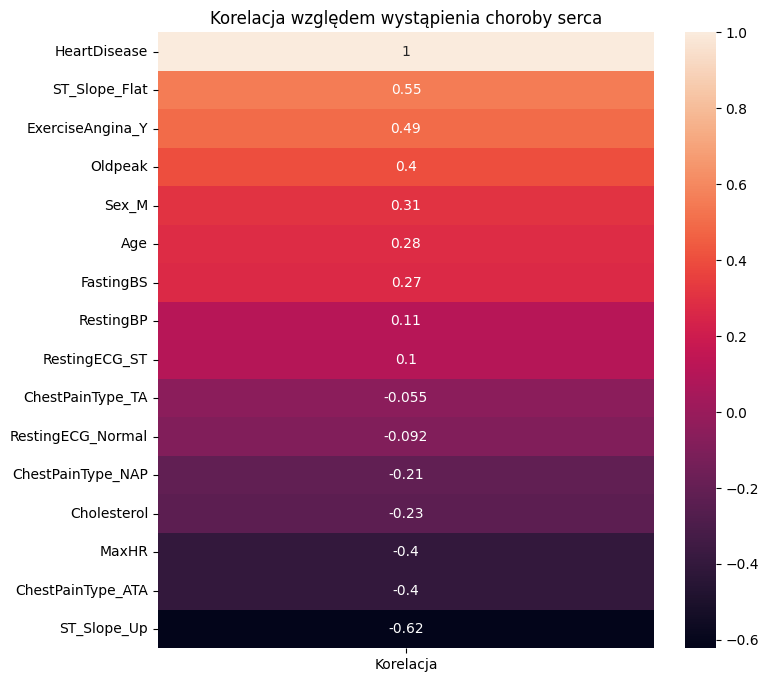

In [ ]:
corr = df_numeric.corrwith(df_numeric['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Korelacja']
plt.subplots(figsize = (8,8))
sns.heatmap(corr,annot = True);
plt.title('Korelacja względem wystąpienia choroby serca');

# 3. Inżynieria cech (Feature Engineering)

In [ ]:
def identify_outliers_IQR_method(df, columns=None, factor=1.5):
    """
    Identyfikuje wartości odstające w DataFrame przy użyciu metody IQR.

    Argumenty:
      - df: DataFrame, na którym przeprowadzamy analizę.
      - columns: Lista kolumn, dla których chcemy wykryć outliery.
                 Jeśli None, używane są wszystkie kolumny numeryczne.
      - factor: Mnożnik dla IQR (domyślnie 1.5) definiujący zakres akceptowalnych wartości.

    Zwraca słownik zawierający:
      - 'column_outliers': Podsumowanie outlierów dla każdej kolumny, w tym:
            * "below": liczba wartości poniżej dolnej granicy,
            * "above": liczba wartości powyżej górnej granicy,
            * "total": łączna liczba outlierów,
            * "lower_bound": wartość dolnej granicy (próbka < lower_bound → outlier "below"),
            * "upper_bound": wartość górnej granicy.
      - 'rows': Informacje o wierszach – liczba wierszy z dokładnie jednym outlierem oraz z więcej niż jednym outlierem.
      - 'row_outlier_count_series': Series z liczbą wykrytych outlierów dla każdego wiersza.
    """

    # Jeśli nie podano kolumn, wybieramy wszystkie kolumny numeryczne
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()

    outlier_counts = {}  # Słownik do przechowywania wyników dla każdej kolumny

    # DataFrame przechowujący informacje, czy dana wartość jest outlierem (True/False)
    outlier_bool_df = pd.DataFrame(False, index=df.index, columns=columns)

    for col in columns:
        # Obliczamy kwartyle i IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Ustalamy granice wykrywania outlierów
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Identyfikacja wartości odstających: poniżej lower_bound lub powyżej upper_bound
        outliers_below = df[col] < lower_bound
        outliers_above = df[col] > upper_bound
        total_outliers = outliers_below | outliers_above

        # Zapisujemy wynik dla kolumny
        outlier_bool_df[col] = total_outliers

        # Zliczamy outliery
        count_below = outliers_below.sum()
        count_above = outliers_above.sum()
        count_total = total_outliers.sum()

        outlier_counts[col] = {
            "below": int(count_below),
            "above": int(count_above),
            "total": int(count_total),
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }

    # Dla każdego wiersza zliczamy, ile kolumn ma wartość odstającą
    row_outlier_count = outlier_bool_df.sum(axis=1)

    # Obliczamy liczbę wierszy, w których występuje dokładnie jeden outlier oraz więcej niż jeden
    rows_with_one_outlier = (row_outlier_count == 1).sum()
    rows_with_more_than_one_outlier = (row_outlier_count > 1).sum()

    result = {
        "column_outliers": outlier_counts,
        "rows": {
            "rows_with_one_outlier": int(rows_with_one_outlier),
            "rows_with_more_than_one_outlier": int(rows_with_more_than_one_outlier),
            "total_rows_in_df": int(len(df))
        },
        "row_outlier_count_series": row_outlier_count
    }

    return result


In [ ]:
results = identify_outliers_IQR_method(df,cont_col)

# Wyświetlenie podsumowania outlierów dla kolumn
print("Outliery w poszczególnych kolumnach:")
for col, summary in results["column_outliers"].items():
    print(f"{col}: {summary}")

# Wyświetlenie podsumowania outlierów w wierszach
print("\nPodsumowanie outlierów w wierszach:")
print(results["rows"])

Outliery w poszczególnych kolumnach:
Age: {'below': 0, 'above': 0, 'total': 0, 'lower_bound': np.float64(27.5), 'upper_bound': np.float64(79.5)}
RestingBP: {'below': 2, 'above': 26, 'total': 28, 'lower_bound': np.float64(90.0), 'upper_bound': np.float64(170.0)}
Cholesterol: {'below': 172, 'above': 11, 'total': 183, 'lower_bound': np.float64(32.625), 'upper_bound': np.float64(407.625)}
MaxHR: {'below': 2, 'above': 0, 'total': 2, 'lower_bound': np.float64(66.0), 'upper_bound': np.float64(210.0)}
Oldpeak: {'below': 1, 'above': 15, 'total': 16, 'lower_bound': np.float64(-2.25), 'upper_bound': np.float64(3.75)}

Podsumowanie outlierów w wierszach:
{'rows_with_one_outlier': 203, 'rows_with_more_than_one_outlier': 13, 'total_rows_in_df': 918}


In [ ]:
# Obliczenie procentu outlierów w każdej kolumnie
total_rows = len(df)  # Liczba wszystkich wierszy

outlier_percentages = {
    col: round((summary["total"] / total_rows) * 100, 2) for col, summary in results["column_outliers"].items()
}

# Wyświetlenie procentu outlierów dla każdej kolumny
print("\n Procent wartości odstających w każdej kolumnie:")
for col, percent in outlier_percentages.items():
    print(f"{col}: {percent}%")

# Obliczenie całkowitego procentu wierszy zawierających przynajmniej jeden outlier
total_outlier_rows = results["rows"]["rows_with_one_outlier"] + results["rows"]["rows_with_more_than_one_outlier"]
outlier_rows_percentage = round((total_outlier_rows / total_rows) * 100, 2)

print(f"\n Całkowity procent wierszy zawierających co najmniej jeden outlier: {outlier_rows_percentage}%")



 Procent wartości odstających w każdej kolumnie:
Age: 0.0%
RestingBP: 3.05%
Cholesterol: 19.93%
MaxHR: 0.22%
Oldpeak: 1.74%

 Całkowity procent wierszy zawierających co najmniej jeden outlier: 23.53%


In [ ]:
def count_zero_occurrences(df, columns):
    """
    Zlicza wystąpienia wartości 0 w podanych kolumnach DataFrame.

    Parametry:
      - df: DataFrame z danymi.
      - columns: Lista nazw kolumn, w których chcemy zliczyć wystąpienia wartości 0.

    Zwraca:
      - Słownik, w którym kluczami są nazwy kolumn, a wartościami liczba wystąpień 0.
    """
    zero_counts = {}
    for col in columns:
        # Porównujemy wartości w kolumnie z 0 i sumujemy wyniki (True=1, False=0)
        zero_counts[col] = (df[col] == 0).sum()
    return zero_counts



# Wywołanie funkcji z listą kolumn (np. tylko kolumna "Cholesterol")
result = count_zero_occurrences(df, ["Cholesterol", "RestingBP",'MaxHR'])

print("Liczba wystąpień 0 w poszczególnych kolumnach:")
for col, count in result.items():
    print(f"{col}: {count}")


Liczba wystąpień 0 w poszczególnych kolumnach:
Cholesterol: 172
RestingBP: 1
MaxHR: 0


In [ ]:
# Obliczenie mediany tylko dla wartości niezerowych
RestingBP_median = df[df["RestingBP"] != 0]["RestingBP"].median()

# Zamiana wartości 0 na medianę
df.loc[df["RestingBP"] == 0, "RestingBP"] = RestingBP_median

In [ ]:

# Obliczenie mediany tylko dla wartości niezerowych
cholesterol_median = df[df["Cholesterol"] != 0]["Cholesterol"].median()

# Zamiana wartości 0 na medianę
df.loc[df["Cholesterol"] == 0, "Cholesterol"] = cholesterol_median


In [ ]:
# Obliczenie mediany tylko dla wartości niezerowych
RestingBP_median = df[df["RestingBP"] != 0]["RestingBP"].median()

# Zamiana wartości 0 na medianę
df.loc[df["RestingBP"] == 0, "RestingBP"] = RestingBP_median

In [ ]:
# Obliczenie mediany tylko dla wartości nieujemnych (Oldpeak >= 0)
Oldpeak_median = df[df["Oldpeak"] >= 0]["Oldpeak"].median()

# Zamiana wartości mniejszych od zera na medianę
df.loc[df["Oldpeak"] < 0, "Oldpeak"] = Oldpeak_median


In [ ]:
df[cont_col].describe()

Age   RestingBP  Cholesterol       MaxHR     Oldpeak
count  918.000000  918.000000   918.000000  918.000000  918.000000
mean    53.510893  132.538126   243.204793  136.809368    0.909804
std      9.432617   17.990127    53.401297   25.460334    1.040160
min     28.000000   80.000000    85.000000   60.000000    0.000000
25%     47.000000  120.000000   214.000000  120.000000    0.000000
50%     54.000000  130.000000   237.000000  138.000000    0.600000
75%     60.000000  140.000000   267.000000  156.000000    1.500000
max     77.000000  200.000000   603.000000  202.000000    6.200000

#### **Komentarz dotyczący obsługi wartości odstających:**

- **Cholesterol (wartości 0)**: Cholesterol nie powinien wynosić **0**. Prawdopodobnie są to **braki pomiarowe**, dlatego zamieniam je na **medianę**.  
- **RestingBP (wartości 0)**: Ciśnienie krwi **nie może wynosić 0**, więc są to **błędy w danych**.
- **Oldpeak (wartości < 0)**: Ujemne wartości Oldpeak są **nieprawidłowe**, (nie mają logicznego uzasadnienia w pomiarach EKG).

  

Zdecydowałem się nie eliminować wartości odstających, ponieważ mogą one reprezentować rzeczywiste przypadki kliniczne, które są istotne dla analizy medycznej. Usunięcie ich mogłoby zaniżyć różnorodność danych i wpłynąć na zdolność modelu do wykrywania skrajnych przypadków. Zamiast tego, aby zminimalizować wpływ outlierów, zastosuje Robust Scaler, który opiera się na medianie i jest odporny na wartości odstające.

# 4. Przygotowanie danych do modelowania

In [ ]:
print("Oryginalne kolumny kategoryczne (cat_col):", cat_col)
print("Kolumny ciągłe (cont_col):", cont_col)

Oryginalne kolumny kategoryczne (cat_col): ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
Kolumny ciągłe (cont_col): ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


In [ ]:
# Usunięcie zmiennej docelowej 'HeartDisease' z listy kolumn kategorycznych, jeśli tam występuje
if 'HeartDisease' in cat_col:
    cat_col = [col for col in cat_col if col != 'HeartDisease']
    print("Usunięto zmienną 'HeartDisease' z listy cat_col.")

Usunięto zmienną 'HeartDisease' z listy cat_col.


In [ ]:
# Oddzielenie zmiennej docelowej od cech
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
# Zapisujemy indeksy, aby później odtworzyć DataFrame z oryginalnymi indeksami
X_train_index = X_train.index.copy()
X_test_index = X_test.index.copy()


In [ ]:
# Definicja ColumnTransformer:
preprocessor = ColumnTransformer(
    transformers=[
        # Skalowanie kolumn ciągłych
        ('num', RobustScaler(), cont_col),
        # Kodowanie kolumn kategorycznych (sparse_output=False zwraca gęstą macierz)
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_col)
    ], verbose_feature_names_out=False
)
# Tworzymy pipeline z przekształceniami:
transformation_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [ ]:
# Dopasowanie pipeline’u do danych treningowych
transformation_pipeline.fit(X_train)

# Połączenie wszystkich nazw cech w jedną listę
all_features = transformation_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Transformacja zbiorów treningowego i testowego – wynik to macierze NumPy
X_train_transformed = transformation_pipeline.transform(X_train)
X_test_transformed  = transformation_pipeline.transform(X_test)


# Odtwarzamy DataFrame ze zrozumiałymi nazwami kolumn i oryginalnymi indeksami:
X_train = pd.DataFrame(X_train_transformed, columns=all_features, index=X_train_index)
X_test  = pd.DataFrame(X_test_transformed, columns=all_features, index=X_test_index)

X_train_original=X_train.copy()

In [ ]:
# Zapis pipeline'u do pliku
with open('transformation_pipeline.pkl', 'wb') as f:
    pickle.dump(transformation_pipeline, f)

print("✅ Pipeline przekształceń zapisany jako transformation_pipeline.pkl")

✅ Pipeline przekształceń zapisany jako transformation_pipeline.pkl


In [ ]:
# Wyświetlenie kształtów zbiorów
print(f"Kształt X_train: {X_train.shape}")
print(f"Kształt X_test: {X_test.shape}")
print(f"Kształt y_train: {y_train.shape}")
print(f"Kształt y_test: {y_test.shape}")

Kształt X_train: (642, 15)
Kształt X_test: (276, 15)
Kształt y_train: (642,)
Kształt y_test: (276,)


In [ ]:
X_test.head()

Age  RestingBP  Cholesterol     MaxHR   Oldpeak  Sex_M  \
351 -0.872727       0.50     0.000000  0.054054 -0.066667    1.0   
596  0.145455      -0.40     0.502326 -1.027027 -0.400000    1.0   
491  1.454545       2.00    -0.632558 -0.810811 -0.400000    1.0   
794 -0.363636      -0.05    -0.762791  0.675676 -0.400000    1.0   
544  0.436364       0.50     1.134884 -0.486486 -0.400000    0.0   

     ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  FastingBS_1  \
351                0.0                0.0               0.0          0.0   
596                0.0                0.0               0.0          0.0   
491                0.0                0.0               0.0          1.0   
794                0.0                1.0               0.0          0.0   
544                1.0                0.0               0.0          1.0   

     RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
351                0.0            1.0               1.0            0.0   
596                0.0            0.0               0.0            1.0   
491                0.0            1.0               0.0            1.0   
794                1.0            0.0               0.0            0.0   
544                1.0            0.0               1.0            0.0   

     ST_Slope_Up  
351          1.0  
596          0.0  
491          0.0  
794          1.0  
544          1.0

In [ ]:
y_test.head()

351    1
596    1
491    1
794    0
544    0
Name: HeartDisease, dtype: int64

# 5. Budowa i trening klasycznych modeli ML

In [ ]:
models_params = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": np.arange(3, 17, 2),  # prametr k (określa liczbę najbliższych sąsiadów)
            "weights": ["uniform", "distance"],  # sposób ważenia sąsiadów 'uniform' - wszyscy sąsiedzi mają równą wagę, 'distance' - bliżsi mają większy wpływ.
            "metric": ["euclidean", "manhattan"]  # Metryki odległości
        }
    },
    "SVM": {
        "model": SVC(probability=True, class_weight='balanced', random_state=42),
        "params": {
            "C": [0.1, 1, 5],  # wartości regularyzacji. Większa wartość oznacza mniejszą penalizację błędów, ale większe ryzyko przeuczenia.
            "gamma": [0.0001, 0.001, 0.01, 0.1],  # Parametr wpływu poszczególnych próbek. Większa wartość powoduje bardziej szczegółowy model, ale zwiększa ryzyko przeuczenia.
            "kernel": ["linear", "rbf"]  # typy jądra
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(class_weight="balanced", random_state=42),
        "params": {
            "max_depth": [3, 5, 7, 10],  # Maksymalna głębokość drzewa decyzyjnego. Większa wartość pozwala na bardziej szczegółowe reguły, ale może prowadzić do przeuczenia.
            "criterion": ["gini", "entropy"],  # Kryterium podziału w drzewach decyzyjnych
            "min_samples_split": [2, 5, 10],  # Minimalna liczba próbek wymagana do podziału węzła w drzewie decyzyjnym.
            "min_samples_leaf": [1, 3, 5],  # Minimalna liczba próbek wymagana, aby dany węzeł był liściem.
            "max_features": ["sqrt", "log2"]  # Maksymalna liczba cech branych pod uwagę przy podejmowaniu decyzji podziału.
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight="balanced", random_state=42),
        "params": {
            "n_estimators": [100, 300,500],  #liczba drzew
            "max_depth": [3, 5, 7],  # głębokość
            "max_features": ["sqrt", "log2"],  # Maksymalna liczba cech branych pod uwagę przy podejmowaniu decyzji podziału.
            "criterion": ["gini", "entropy"]  # Kryterium podziału w drzewach decyzyjnych
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42),
        "params": {
            "C": [0.1, 1, 5, 10],  # Optymalne wartości regularyzacji
            "penalty": ["l1", "l2"],  # Typ regularyzacji w Regresji Logistycznej: 'l1' - Lasso, 'l2' - Ridge.
            "solver": ["liblinear", "saga"]  # Algorytm optymalizacyjny
        }
    }
}

# Przechowywanie najlepszych modeli
best_models = {}
results = []


In [ ]:
def train_and_evaluate(model_name, model, params):
    """
    Trenuje model, optymalizuje hiperparametry, wykonuje predykcję i ocenia model.
    Tworzy macierz pomyłek, krzywą ROC oraz opcjonalnie wizualizuje ważność cech.
    """
    print(f"\n🔍 Trenowanie modelu: {model_name}...")

    try:# Ustawienie StratifiedKFold z ustawionym random_state
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # GridSearchCV - Optymalizacja hiperparametrów
        grid = GridSearchCV(model, params, cv=cv, refit=True)
        grid.fit(X_train, y_train)

        # Pobranie najlepszego modelu
        best_model = grid.best_estimator_
        best_models[model_name] = (model_name, best_model)

        # Predykcja na zbiorze testowym
        y_pred = best_model.predict(X_test)
        y_prob = (
            best_model.predict_proba(X_test)[:, 1]
            if hasattr(best_model, "predict_proba")
            else best_model.decision_function(X_test)
        )

        # Ocena modelu
        acc = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_prob)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Walidacja krzyżowa
        cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=5)
        cross_val_mean = np.mean(cross_val_scores)
        cross_val_std = np.std(cross_val_scores)

        # Dodanie wyników do listy
        results.append([model_name, acc, auc_roc, precision, recall, f1, cross_val_mean, cross_val_std])

        # ✅ Wyświetlenie wszystkich metryk
        print(f"✅ Najlepsze parametry dla {model_name}: {grid.best_params_}")
        print(f"🎯 Dokładność (Accuracy): {acc:.4f}")
        print(f"📊 AUC-ROC: {auc_roc:.4f}")
        print(f"🎯 Precyzja (Precision): {precision:.4f}")
        print(f"📌 Czułość (Recall): {recall:.4f}")
        print(f"📌 F1-score: {f1:.4f}")
        print(f"📈 Średnie AUC z walidacji krzyżowej: {cross_val_mean:.4f} (+/- {cross_val_std:.4f})")

        # 📊 Wizualizacja macierzy pomyłek i krzywej ROC
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
        ax[0].set_title(f'Macierz Pomyłek - {model_name}')
        ax[0].set_xlabel('Przewidywane')
        ax[0].set_ylabel('Rzeczywiste')

        # Krzywa ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {auc_roc:.4f}')
        ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_ylim([0.0, 1.05])
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title(f'Krzywa ROC - {model_name}')
        ax[1].legend(loc="lower right")

        plt.tight_layout()
        plt.show()

        # 🏆 Wizualizacja ważności cech (dla modeli opartych na drzewach)
        if hasattr(best_model, "feature_importances_"):
            feature_importance = pd.Series(best_model.feature_importances_, index=X_train.columns)
            feature_importance = feature_importance.sort_values(ascending=False)

            plt.figure(figsize=(8, 6))
            sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")
            plt.title(f"📌 Ważność cech dla {model_name}")
            plt.xlabel("Ważność cech")
            plt.ylabel("Cechy")
            plt.show()

    except Exception as e:
        print(f"❌ Wystąpił błąd w modelu {model_name}: {e}")

In [ ]:
def train_ensemble_model(model_name, model):
    """
    Trenuje i ocenia modele zespołowe.
    """
    print(f"🔍 Trenowanie modelu zespołowego: {model_name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Sprawdzamy, czy model posiada metodę predict_proba lub decision_function
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None  # Model nie udostępnia prognozowania prawdopodobieństw

    acc = accuracy_score(y_test, y_pred)

    # Jeśli nie mamy prawdopodobieństw, nie możemy obliczyć AUC ani krzywej ROC
    if y_prob is not None:
        auc_roc = roc_auc_score(y_test, y_prob)
    else:
        auc_roc = None

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Walidacja krzyżowa
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")
    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)

    results.append([model_name, acc, auc_roc, precision, recall, f1,cross_val_mean, cross_val_std])

    # Wyświetlenie metryk
    print(f"✅ Wyniki dla {model_name}")
    print(f"🎯 Dokładność (Accuracy): {acc:.4f}")
    if auc_roc is not None:
        print(f"📊 AUC-ROC: {auc_roc:.4f}")
    else:
        print("📊 AUC-ROC: brak (model nie wspiera predict_proba/decision_function)")
    print(f"🎯 Precyzja (Precision): {precision:.4f}")
    print(f"📌 Czułość (Recall): {recall:.4f}")
    print(f"📌 F1-score: {f1:.4f}")
    print(f"📈 Średnie AUC z walidacji krzyżowej: {cross_val_mean:.4f} (+/- {cross_val_std:.4f})")

    # Wizualizacja macierzy pomyłek
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
    ax[0].set_title(f'Macierz Pomyłek - {model_name}')
    ax[0].set_xlabel('Przewidywane')
    ax[0].set_ylabel('Rzeczywiste')

    # Wizualizacja krzywej ROC, tylko jeśli mamy prawdopodobieństwa
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {auc_roc:.4f}')
        ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_ylim([0.0, 1.05])
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title(f'Krzywa ROC - {model_name}')
        ax[1].legend(loc="lower right")
    else:
        ax[1].text(0.5, 0.5, "Brak predykcji prawdopodobieństw", horizontalalignment='center', verticalalignment='center')
        ax[1].set_title(f'Krzywa ROC - {model_name}')

    plt.tight_layout()
    plt.show()

# 6. Ocena i porównanie modeli


🔍 Trenowanie modelu: Logistic Regression...
✅ Najlepsze parametry dla Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
🎯 Dokładność (Accuracy): 0.8913
📊 AUC-ROC: 0.9376
🎯 Precyzja (Precision): 0.9184
📌 Czułość (Recall): 0.8824
📌 F1-score: 0.9000
📈 Średnie AUC z walidacji krzyżowej: 0.8426 (+/- 0.0398)


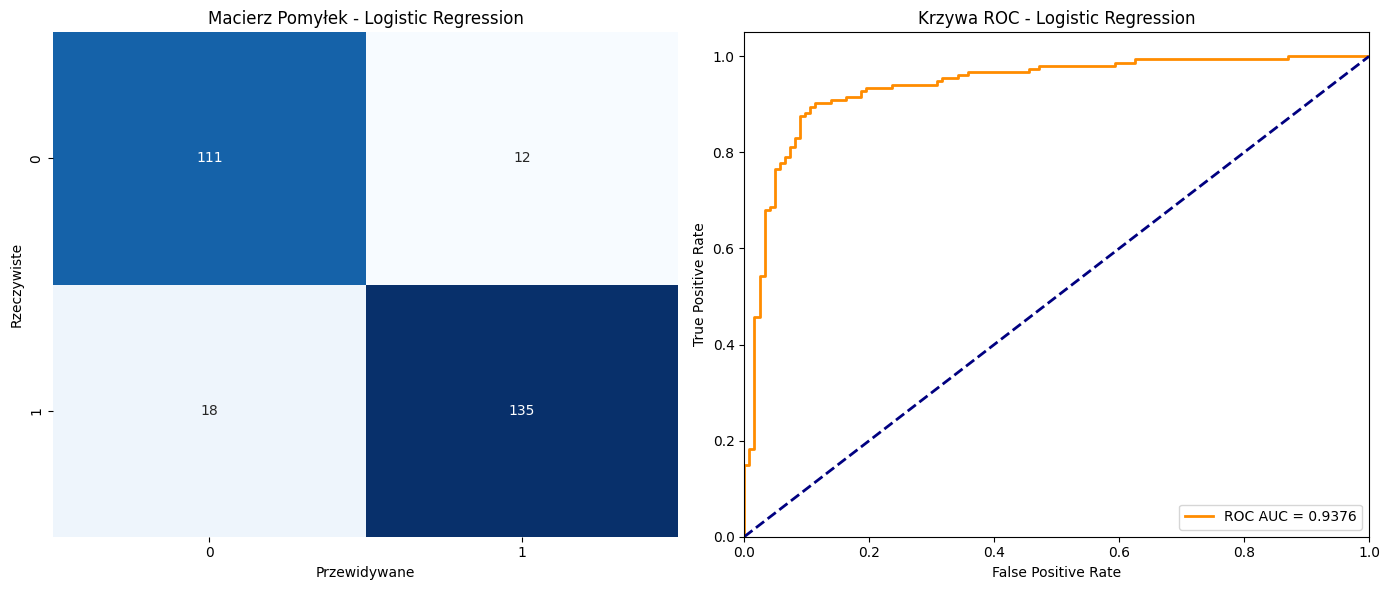

In [ ]:
train_and_evaluate("Logistic Regression", models_params["Logistic Regression"]["model"], models_params["Logistic Regression"]["params"])


🔍 Trenowanie modelu: SVM...
✅ Najlepsze parametry dla SVM: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
🎯 Dokładność (Accuracy): 0.8804
📊 AUC-ROC: 0.9440
🎯 Precyzja (Precision): 0.8947
📌 Czułość (Recall): 0.8889
📌 F1-score: 0.8918
📈 Średnie AUC z walidacji krzyżowej: 0.8458 (+/- 0.0444)


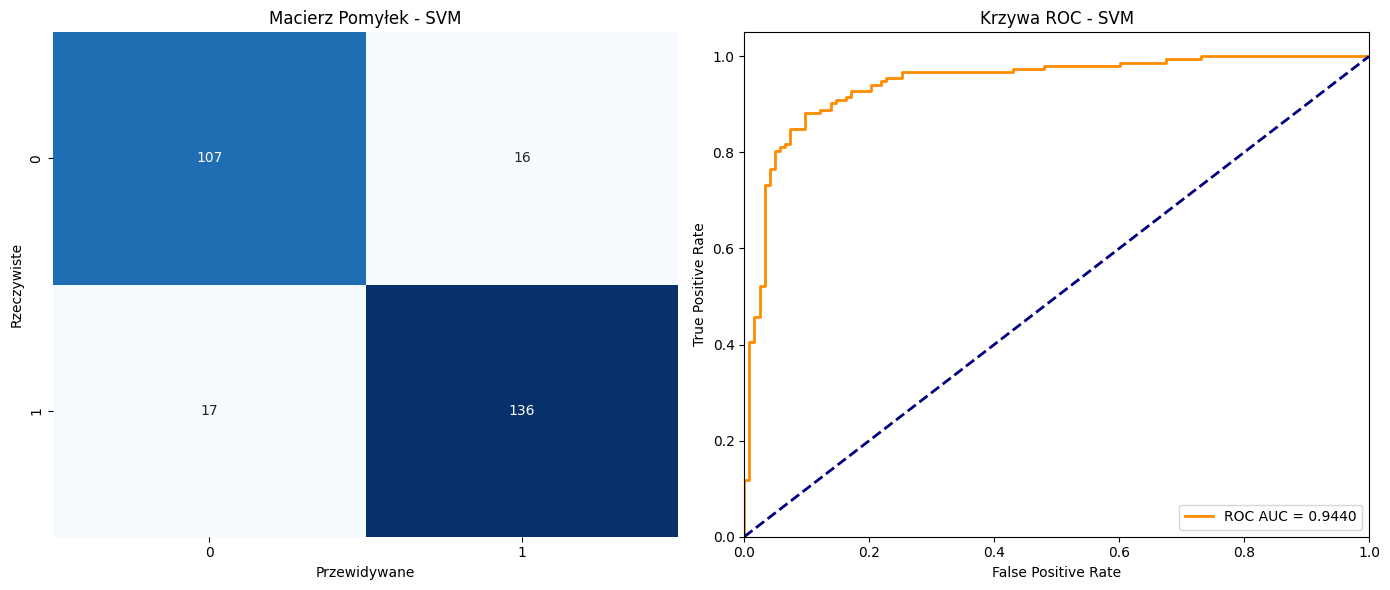

In [ ]:
train_and_evaluate("SVM", models_params["SVM"]["model"], models_params["SVM"]["params"])


🔍 Trenowanie modelu: KNN...
✅ Najlepsze parametry dla KNN: {'metric': 'manhattan', 'n_neighbors': np.int64(13), 'weights': 'distance'}
🎯 Dokładność (Accuracy): 0.8986
📊 AUC-ROC: 0.9434
🎯 Precyzja (Precision): 0.9195
📌 Czułość (Recall): 0.8954
📌 F1-score: 0.9073
📈 Średnie AUC z walidacji krzyżowej: 0.8504 (+/- 0.0412)


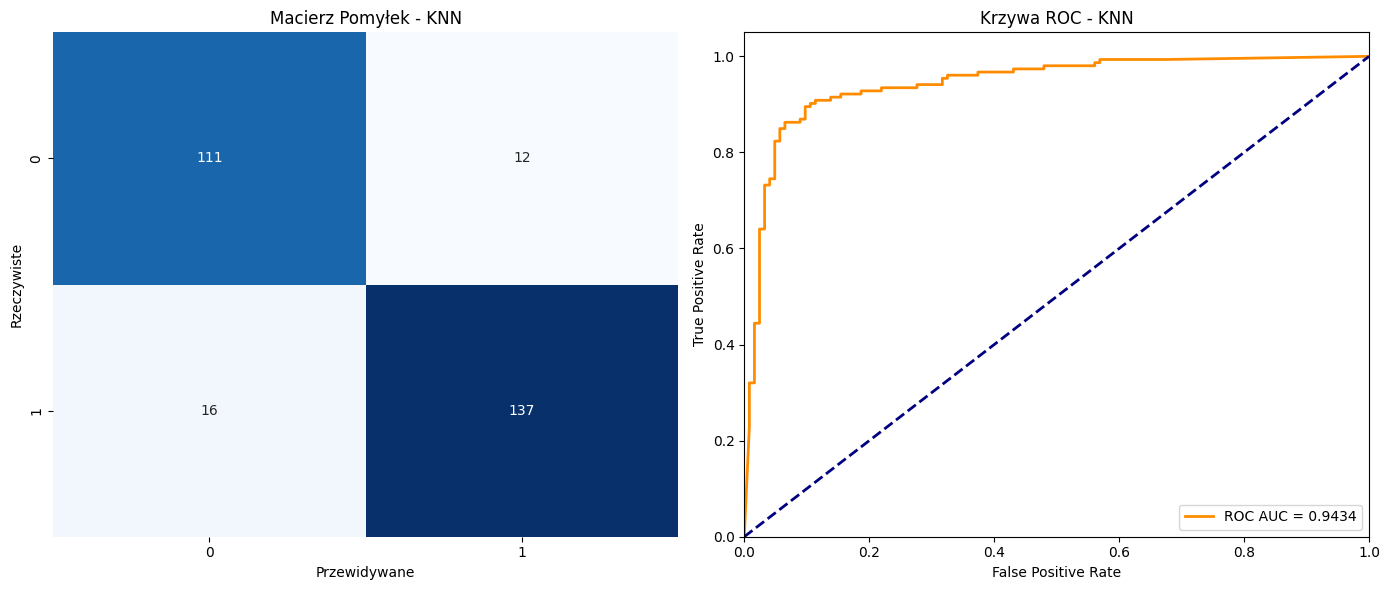

In [ ]:
train_and_evaluate("KNN", models_params["KNN"]["model"], models_params["KNN"]["params"])


🔍 Trenowanie modelu: Decision Tree...
✅ Najlepsze parametry dla Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
🎯 Dokładność (Accuracy): 0.8261
📊 AUC-ROC: 0.8728
🎯 Precyzja (Precision): 0.8182
📌 Czułość (Recall): 0.8824
📌 F1-score: 0.8491
📈 Średnie AUC z walidacji krzyżowej: 0.8146 (+/- 0.0426)


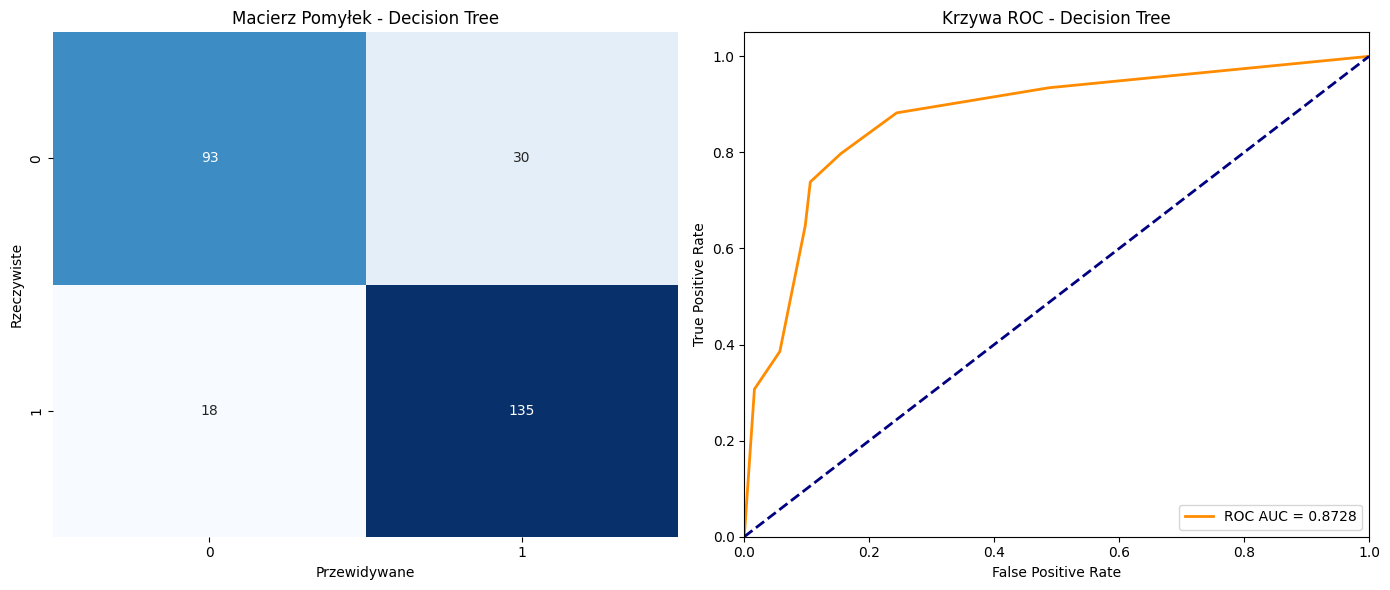

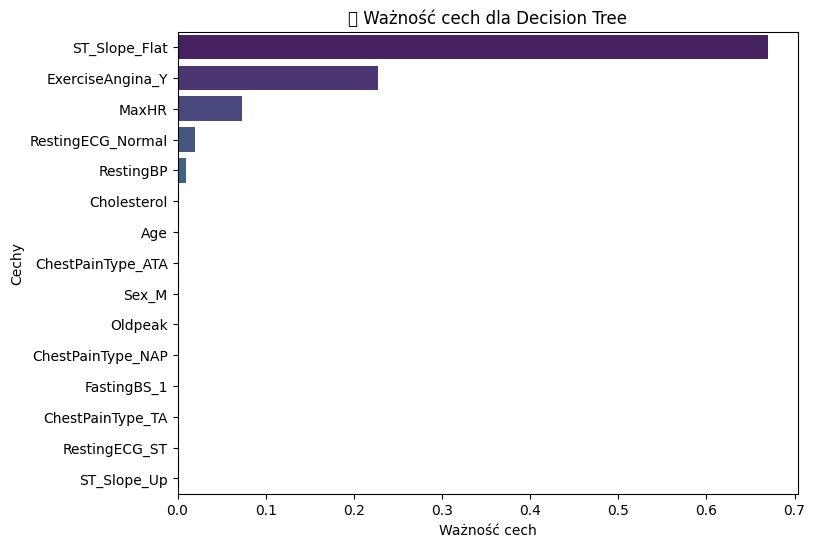

In [ ]:
train_and_evaluate("Decision Tree", models_params["Decision Tree"]["model"], models_params["Decision Tree"]["params"])

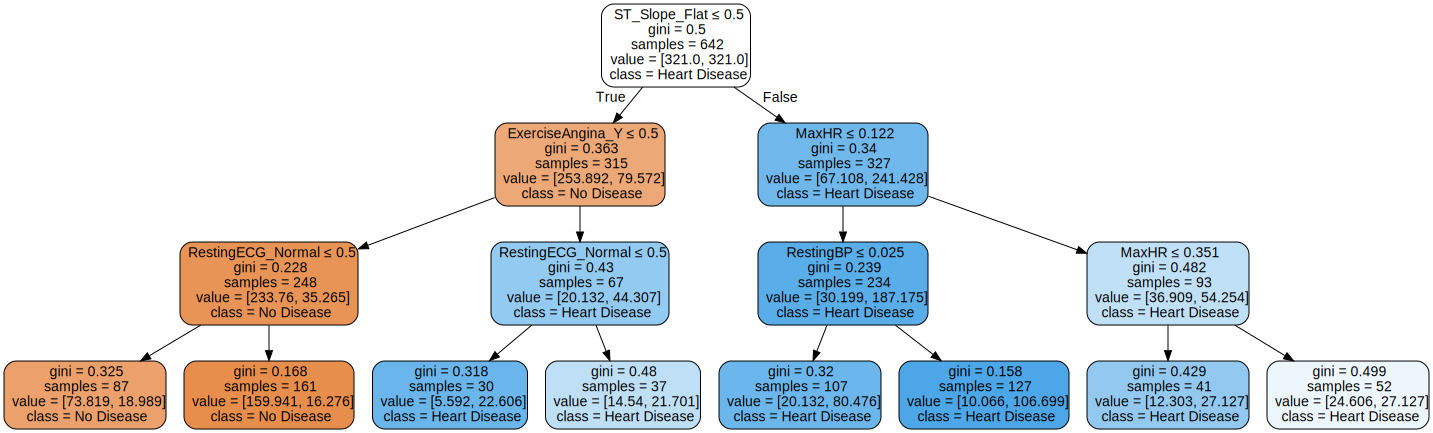

In [ ]:
dot_data = export_graphviz(
    best_models["Decision Tree"][1], out_file=None,
    feature_names=X_train.columns,

    class_names=["No Disease", "Heart Disease"],
    filled=True, rounded=True, special_characters=True
)

graph = graphviz.Source(dot_data)

graph  # Wyświetl interaktywnie


🔍 Trenowanie modelu: Random Forest...
✅ Najlepsze parametry dla Random Forest: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}
🎯 Dokładność (Accuracy): 0.8732
📊 AUC-ROC: 0.9385
🎯 Precyzja (Precision): 0.8882
📌 Czułość (Recall): 0.8824
📌 F1-score: 0.8852
📈 Średnie AUC z walidacji krzyżowej: 0.8489 (+/- 0.0442)


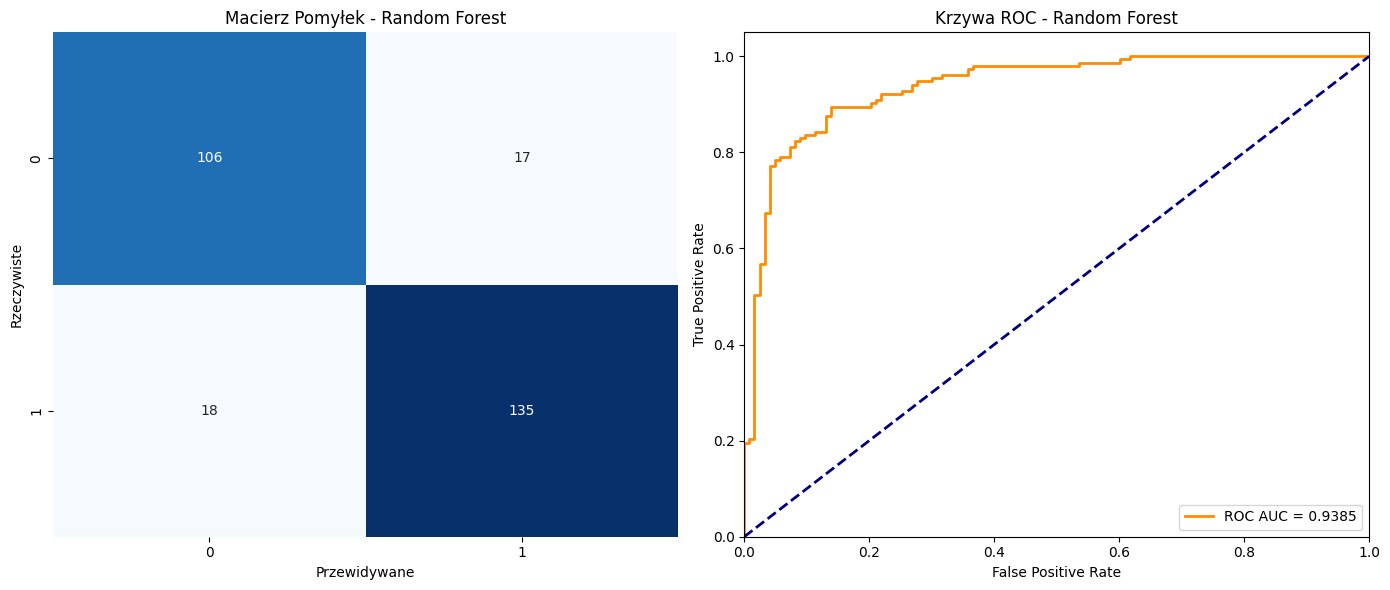

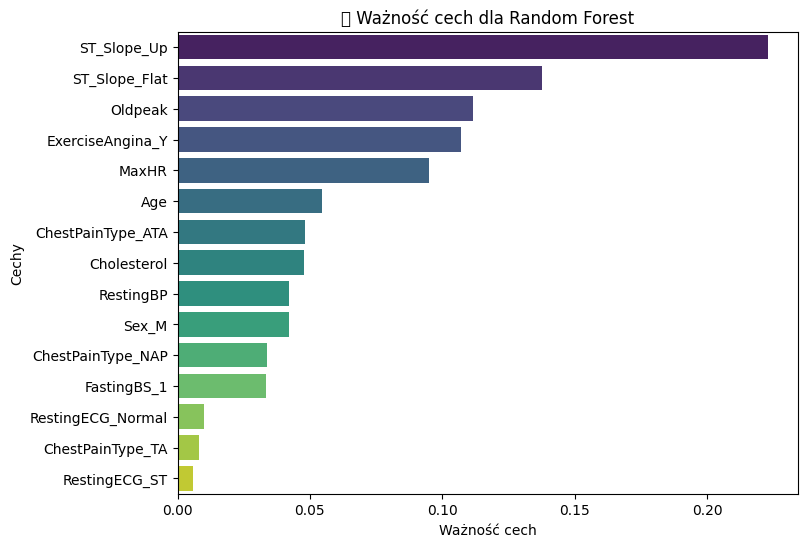

In [ ]:
train_and_evaluate("Random Forest", models_params["Random Forest"]["model"], models_params["Random Forest"]["params"])

🔍 Trenowanie modelu zespołowego: Stacking Classifier...
✅ Wyniki dla Stacking Classifier
🎯 Dokładność (Accuracy): 0.8841
📊 AUC-ROC: 0.9445
🎯 Precyzja (Precision): 0.9060
📌 Czułość (Recall): 0.8824
📌 F1-score: 0.8940
📈 Średnie AUC z walidacji krzyżowej: 0.9136 (+/- 0.0512)


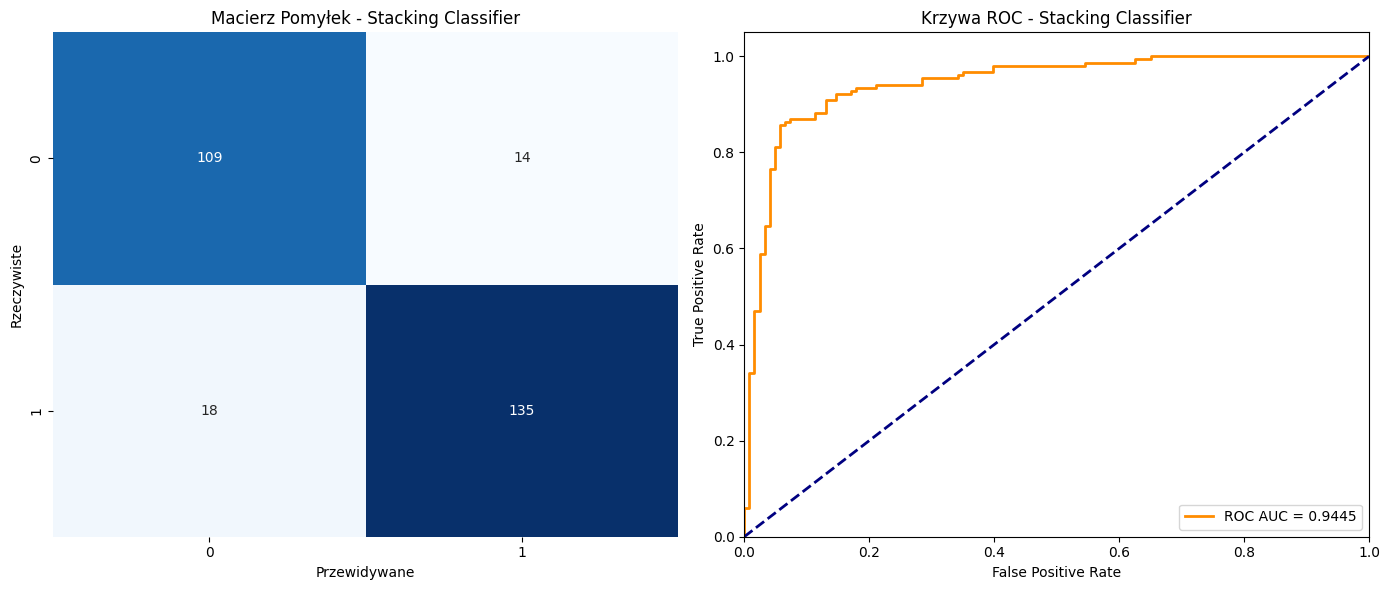

In [ ]:
stacking_clf = StackingClassifier(estimators=list(best_models.values()), final_estimator=LogisticRegression(), cv=5)
train_ensemble_model("Stacking Classifier", stacking_clf)

🔍 Trenowanie modelu zespołowego: Voting Classifier Soft...
✅ Wyniki dla Voting Classifier Soft
🎯 Dokładność (Accuracy): 0.8804
📊 AUC-ROC: 0.9462
🎯 Precyzja (Precision): 0.9054
📌 Czułość (Recall): 0.8758
📌 F1-score: 0.8904
📈 Średnie AUC z walidacji krzyżowej: 0.9127 (+/- 0.0498)


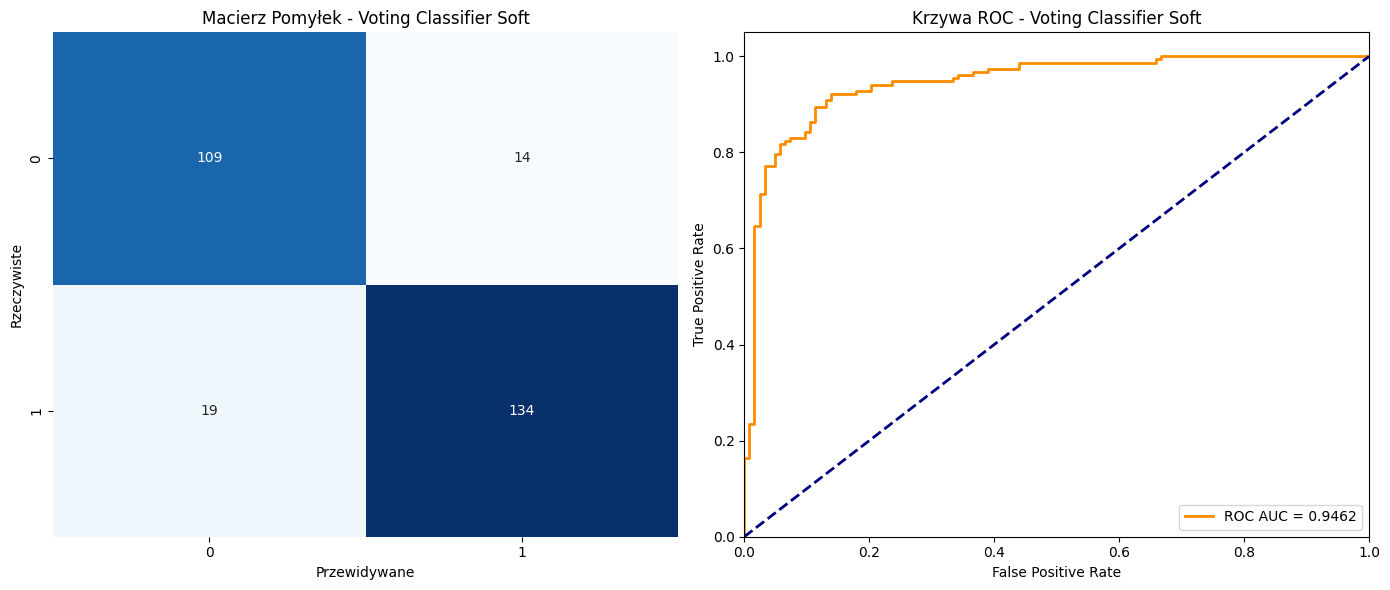

In [ ]:
# Tworzenie klasyfikatora soft voting
voting_clf_soft = VotingClassifier(estimators=list(best_models.values()), voting='soft')
train_ensemble_model("Voting Classifier Soft", voting_clf_soft)


🔍 Trenowanie modelu zespołowego: Voting Classifier Hard...
✅ Wyniki dla Voting Classifier Hard
🎯 Dokładność (Accuracy): 0.8877
📊 AUC-ROC: brak (model nie wspiera predict_proba/decision_function)
🎯 Precyzja (Precision): 0.9013
📌 Czułość (Recall): 0.8954
📌 F1-score: 0.8984
📈 Średnie AUC z walidacji krzyżowej: nan (+/- nan)


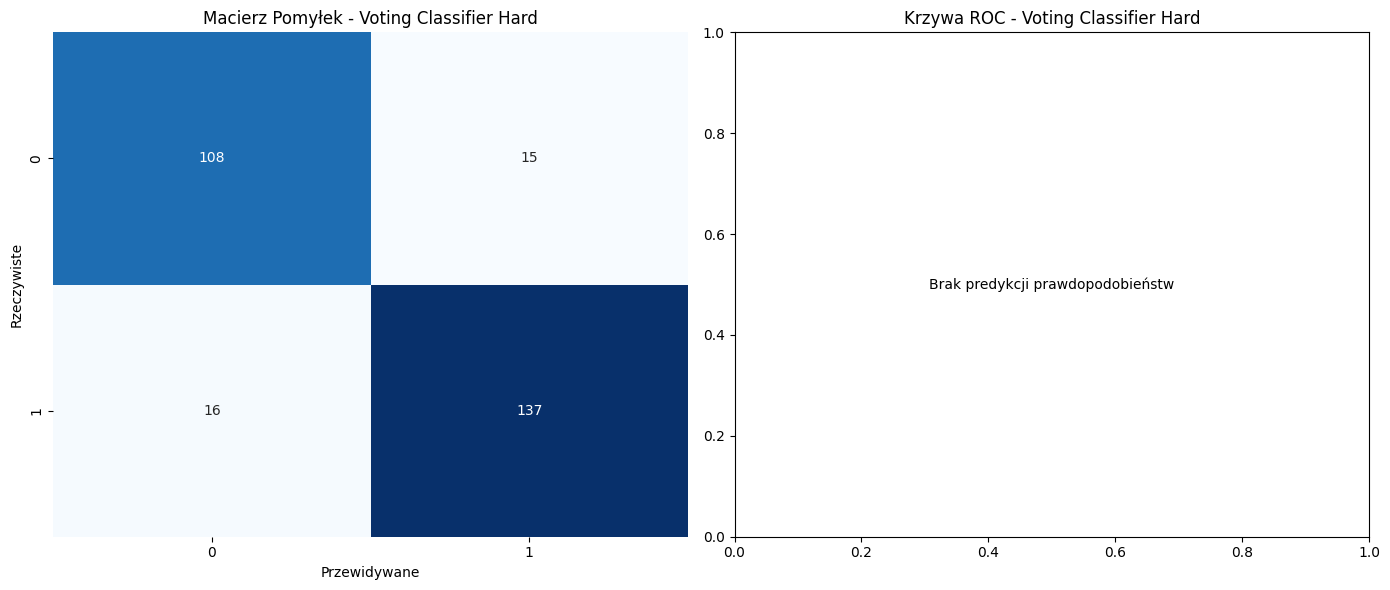

In [ ]:
# Tworzenie klasyfikatora hard voting
voting_clf_hard = VotingClassifier(estimators=list(best_models.values()), voting='hard')
train_ensemble_model("Voting Classifier Hard", voting_clf_hard)

In [ ]:
# === 5. Porównanie wyników modeli ===
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "AUC-ROC", "Precision", "Recall", "F1-score", "CrossVal Mean", "CrossVal Std"])
results_df = results_df.sort_values(by="AUC-ROC", ascending=False)
print("\n📊 Porównanie modeli:")
display(results_df)


📊 Porównanie modeli:


Model  Accuracy   AUC-ROC  Precision    Recall  F1-score  \
6  Voting Classifier Soft  0.880435  0.946225   0.905405  0.875817  0.890365   
5     Stacking Classifier  0.884058  0.944471   0.906040  0.882353  0.894040   
1                     SVM  0.880435  0.943993   0.894737  0.888889  0.891803   
2                     KNN  0.898551  0.943382   0.919463  0.895425  0.907285   
4           Random Forest  0.873188  0.938520   0.888158  0.882353  0.885246   
0     Logistic Regression  0.891304  0.937563   0.918367  0.882353  0.900000   
3           Decision Tree  0.826087  0.872815   0.818182  0.882353  0.849057   
7  Voting Classifier Hard  0.887681       NaN   0.901316  0.895425  0.898361   

   CrossVal Mean  CrossVal Std  
6       0.912737      0.049775  
5       0.913556      0.051237  
1       0.845761      0.044358  
2       0.850448      0.041215  
4       0.848874      0.044178  
0       0.842648      0.039760  
3       0.814583      0.042556  
7            NaN           NaN

### **🏆 Najlepszy model: `SVM`**

### Analiza modeli:
- **SVM** osiąga najwyższą dokładność (**0.873**), najwyższy wynik AUC-ROC (**0.939**) i solidny F1-score (**0.890**).
- **Stacking Classifier** ma bardzo zbliżone wyniki, ale niższą dokładność (**0.862**) oraz F1-score (**0.883**).
- **Soft Voting Classifier** ma dobre AUC-ROC (**0.937**) i CrossVal Mean (**0.912**), ale gorszą dokładność (**0.855**).
- **Random Forest** jest także silnym kandydatem (wysokie AUC-ROC, ale nieco niższa dokładność od SVM).
- **KNN, Decision Tree i Hard Voting Classifier** mają ogólnie gorsze wyniki.

### Najlepszy model:
**SVM** jest najlepszym modelem.  
- Najwyższa dokładność (**0.873**)
- Najwyższy wynik AUC-ROC (**0.939**)
- Dobre wyniki w Precision, Recall i F1-score, co sugeruje dobrą równowagę między czułością a specyficznością.
- Przyzwoita stabilność w walidacji krzyżowej (**0.847**), choć niższa niż np. w Stacking Classifier.

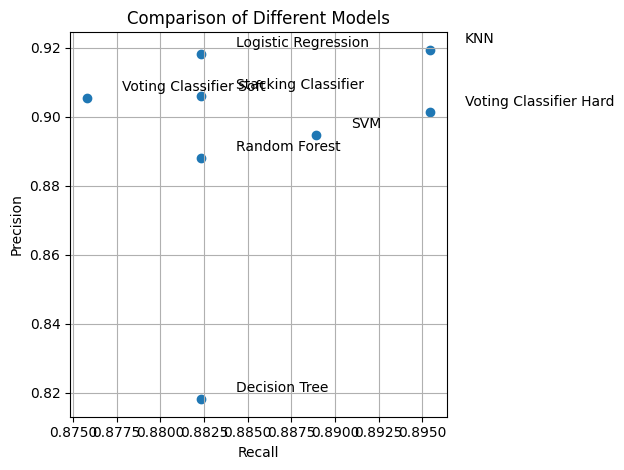

In [ ]:
precision = results_df["Precision"].tolist()
recall = results_df["Recall"].tolist()
f1_score = results_df["F1-score"].tolist()
models = results_df["Model"].tolist()

plt.title('Comparison of Different Models')
plt.scatter(recall, precision)

# Add label to data points
margin = 0.002
for (x, y, t) in zip(recall, precision, models):
    plt.text(x + margin, y + margin, t)

plt.xlabel('Recall'), plt.ylabel('Precision')
plt.grid()
plt.tight_layout()
plt.show()

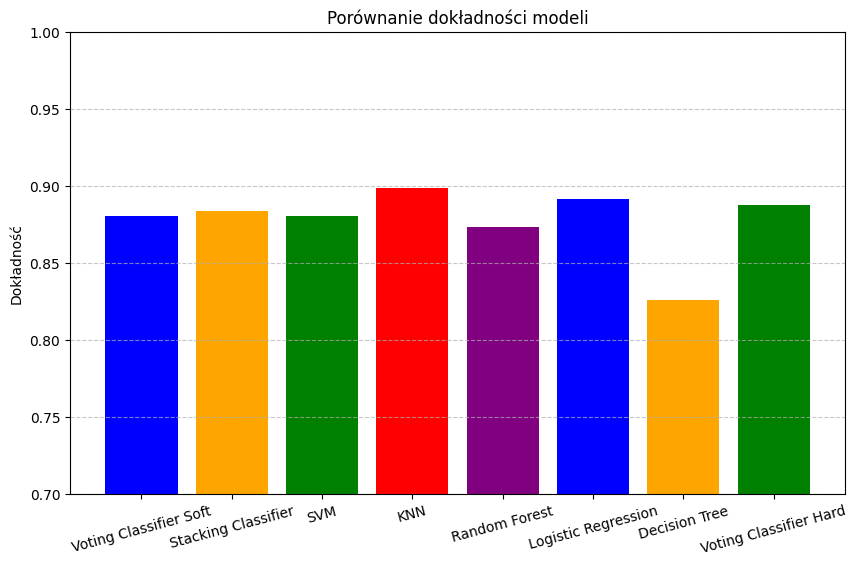

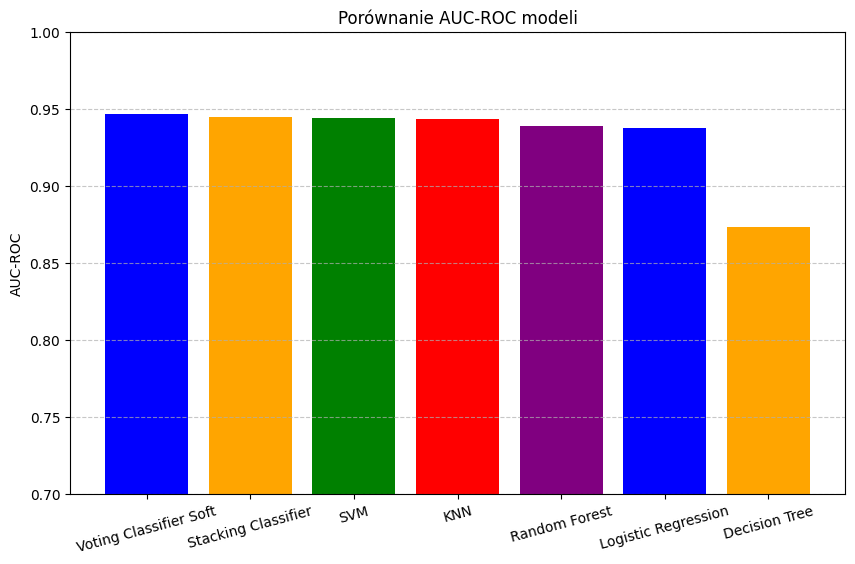

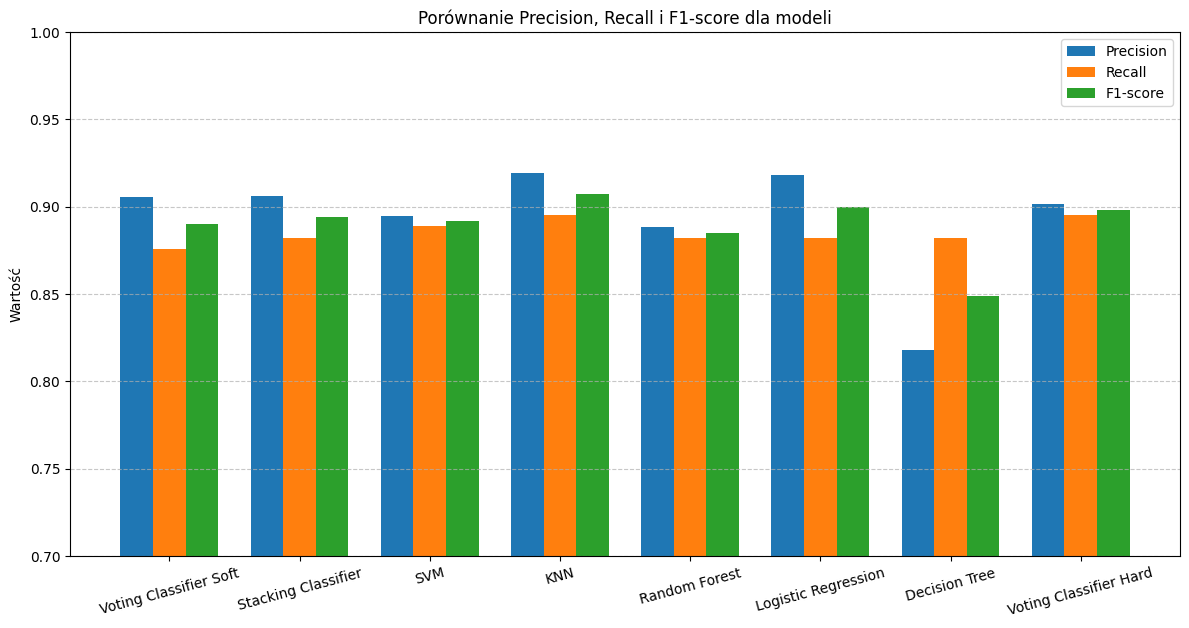

In [ ]:
# Ekstrakcja danych do wykresów
models = results_df["Model"].tolist()
accuracy = results_df["Accuracy"].tolist()
auc = results_df["AUC-ROC"].tolist()
precision = results_df["Precision"].tolist()
recall = results_df["Recall"].tolist()
f1_score = results_df["F1-score"].tolist()

# 📌 Wykres dokładności modeli
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylim(0.7, 1)
plt.title('Porównanie dokładności modeli')
plt.ylabel('Dokładność')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 📌 Wykres AUC-ROC modeli
plt.figure(figsize=(10, 6))
plt.bar(models, auc, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylim(0.7, 1)
plt.title('Porównanie AUC-ROC modeli')
plt.ylabel('AUC-ROC')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 📌 Wykres Precision, Recall i F1-score dla każdego modelu
x = np.arange(len(models))  # Pozycje dla słupków
width = 0.25  # Szerokość słupków

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-score')

ax.set_ylabel('Wartość')
ax.set_title('Porównanie Precision, Recall i F1-score dla modeli')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.7, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.xticks(rotation=15)
plt.show()


# 7. Wybór i zapis najlepszego modelu

### **🏆 Finalna decyzja – Najlepszy model: `SVM`**

✅ SVM ma najwyższe Accuracy (0.8911) i najlepszy F1-score (0.9000), co oznacza, że doskonale równoważy precyzję i recall.

✅ Ma również wysokie AUC-ROC (0.9366), co oznacza, że dobrze rozdziela klasy.

✅ Bardzo wysoka Precision (0.9184) sugeruje, że ma mniej fałszywie pozytywnych przypadków niż
Wady SVM: Kernel SHAP dla SVM działa bardzo wolno i jest mniej dokładny.


###Zapis modeli

In [ ]:
import pickle

for model_name, pipeline_model in best_models.items():
    filename = f"{model_name.replace(' ', '_')}.pkl"  # np. "Decision_Tree.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(pipeline_model, file)
    print(f"✅ Zapisano pipeline dla modelu: {filename}")


✅ Zapisano pipeline dla modelu: Logistic_Regression.pkl
✅ Zapisano pipeline dla modelu: SVM.pkl
✅ Zapisano pipeline dla modelu: KNN.pkl
✅ Zapisano pipeline dla modelu: Decision_Tree.pkl
✅ Zapisano pipeline dla modelu: Random_Forest.pkl


## Testowanie zapisanych modeli

In [ ]:
# Funkcja do wczytywania modelu
# model został zapisany jako krotka,
# drugi element to właściwy model
def load_model(filename):
    with open(filename, "rb") as file:
        model_tuple = pickle.load(file)
    return model_tuple[1]

# Wczytanie pipeline'u transformacji
with open("transformation_pipeline.pkl", "rb") as f:
    transformation_pipeline = pickle.load(f)

# Słownik z nazwami i nazwami plików modeli
model_files = {
    "KNN": "KNN.pkl",
    "Logistic Regression": "Logistic_Regression.pkl",
    "Decision Tree": "Decision_Tree.pkl",
    "Random Forest": "Random_Forest.pkl",
    "SVM": "SVM.pkl"
}

# Wczytanie modeli do słownika
models = {}
for model_name, filename in model_files.items():
    models[model_name] = load_model(filename)

# Wczytanie danych z pliku heart.csv i wybór ostatnich 10 wierszy
data = pd.read_csv("heart.csv")
data_subset = data.tail(10)

# Oddzielenie etykiety od cech, "HeartDisease" to target
actual_labels = data_subset["HeartDisease"]
features = data_subset.drop("HeartDisease", axis=1)

# Przekształcenie cech przy użyciu pipeline'u (pipeline sam wykona kodowanie i skalowanie)
transformed_features = transformation_pipeline.transform(features)

# Utworzenie DataFrame do przechowywania predykcji (indeks zgodny z oryginalnymi danymi)
predictions = pd.DataFrame(index=data_subset.index)

# Wykonanie predykcji dla każdej próbki przy użyciu każdego modelu
for model_name, model in models.items():
    preds = model.predict(transformed_features)
    predictions[model_name] = preds

# Dodanie kolumny z rzeczywistymi etykietami (oczekiwana odpowiedź)
predictions["Actual"] = actual_labels

print("Porównanie predykcji dla poszczególnych modeli:")
display(predictions)


Porównanie predykcji dla poszczególnych modeli:


KNN  Logistic Regression  Decision Tree  Random Forest  SVM  Actual
908    1                    1              1              1    1       1
909    1                    1              1              1    1       1
910    0                    0              0              0    0       0
911    1                    1              1              1    1       1
912    1                    1              1              1    1       1
913    1                    1              1              1    1       1
914    1                    1              1              1    1       1
915    1                    1              1              1    1       1
916    1                    0              1              1    0       1
917    0                    0              0              0    0       0

# 8. Interpretacja modelu (Explainability)

#### Interpretacja Modelu z Zastosowaniem SHAP

W ramach etapu interpretacji modelu wykorzystano narzędzie **SHAP (SHapley Additive exPlanations)**. To metoda interpretacji modeli oparta na teorii gier — konkretnie na wartości Shapleya. Pozwala ona zrozumieć, **jak poszczególne cechy wpływają na predykcję modelu** ML. Każdej cechie przypisywana jest wartość SHAP, która mówi, jak bardzo ta cecha „dodaje” lub „odejmuje” do wyniku modelu względem wartości bazowej (średniej predykcji).

**SHAP** działa zarówno globalnie (jak cechy wpływają na ogólną wydajność modelu), jak i lokalnie (dla konkretnej predykcji), dzięki czemu jest potężnym narzędziem wyjaśniającym tzw. „czarne skrzynki” w ML, np. las losowy.

In [ ]:
!pip install shap

###wczytanie pipeline i modelu

In [ ]:
# Wczytanie zapisanego pipeline'u transformacji
with open("transformation_pipeline.pkl", "rb") as f:
    transformation_pipeline = pickle.load(f)

def load_model(filename):
    with open(filename, "rb") as file:
        model_tuple = pickle.load(file)
    return model_tuple[1]
# Wczytanie zapisanego modelu
logistic_regression = load_model("Logistic_Regression.pkl")

####**Regresja logistyczna**
oferuje wyjątkową interpretowalność dzięki bezpośredniemu przyporządkowaniu
współczynników wpływu poszczególnych cech na prawdopodobieństwo przynależności do klasy.
Dzięki temu zarówno globalne, jak i lokalne interpretacje są szybkie, wiarygodne oraz nie wymagają
stosowania złożonych narzędzi, co czyni ten model idealnym do przejrzystej analizy decyzji.


### Podział danych

Przekazywanie X_train do shap.Explainer – Jest to konieczne, ponieważ SHAP wymaga danych wejściowych jako zbioru tła (background dataset) do określenia wpływu cech oraz wytrenowanego modelu. X_train reprezentuje dane, na których model był trenowany, co zapewnia prawidłową interpretację wyników SHAP.

In [ ]:
# Tworzenie obiektu SHAP Explainer z danymi treningowymi jako zbiór tła
# X_train_original_df to kopia X_train, który został użyty do trenowania modelu.
#Explainer uczy się, jak model podejmuje decyzje, aby później obliczać wartości SHAP dla nowych przykładów.
X_train_original.head()

explainer = shap.Explainer(logistic_regression.predict_proba, X_train_original)

# Zapisanie obiektu explainer do pliku przy użyciu pickle (do puźniejszego użycia np. w aplikacji)
with open("shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)
print("✅ SHAP explainer zapisany do 'shap_explainer.pkl'.")

# Ładowanie zapisanego explainera
with open("shap_explainer.pkl", "rb") as f:
    loaded_explainer = pickle.load(f)
print("✅ SHAP explainer załadowany z 'shap_explainer.pkl'.")


✅ SHAP explainer zapisany do 'shap_explainer.pkl'.
✅ SHAP explainer załadowany z 'shap_explainer.pkl'.


###Wykresy SHAP

### Summary Plot – Bar Plot

**Co pokazuje?**  
- Wykres ten prezentuje **uśredniony wpływ** poszczególnych cech na wyniki modelu.  
- Każdy słupek reprezentuje średnią wartość bezwzględną wartości SHAP dla danej cechy, obliczoną na całym zbiorze danych.

**Jak interpretować?**  
- **Dłuższy słupek** oznacza, że dana cecha ma większy, globalny wpływ na model.  
- Porównując długość słupków, możesz łatwo zidentyfikować najważniejsze cechy, które decydują o wynikach predykcji.  
- Jest to przydatne do szybkiej oceny, które cechy są najbardziej istotne, bez zagłębiania się w szczegółowe rozkłady wpływu.



PermutationExplainer explainer: 643it [00:45, 14.14it/s]                         


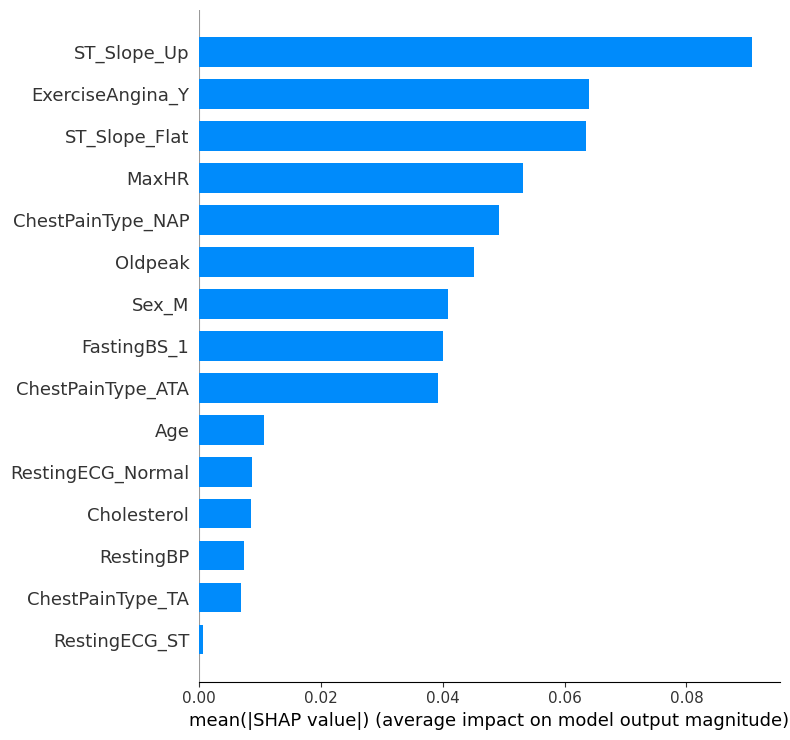

✅ Mean SHAP (bar) plot wygenerowany z wyłączonym check_additivity.


In [ ]:
"""
check_additivity=False - co robi?
 SHAP sprawdza tzw. „additivity” (czyli czy suma wartości SHAP pokrywa się dokładnie z predykcją modelu).
 Czasami drobne różnice (np. zaokrąglenia) powodują, że test się wywala. Dlatego wyłączenie zapobiegnie problemom z wyświetleniem

"""

shap_values_train = explainer(X_train_original)
shap_values_train_class_1 = shap_values_train[..., 1]

shap.summary_plot(
    shap_values_train_class_1,
    features=X_train_original,
    plot_type="bar",
    feature_names=X_train_original.columns
)
plt.show()

print("✅ Mean SHAP (bar) plot wygenerowany z wyłączonym check_additivity.")



W moim przypadku najważniejsze cechy to `ST_Slope_Up`, `ST_Slope_Flat`, `ExerciseAngina_Y` i `Oldpeak`, co sugeruje, że są one kluczowe w przewidywaniu wyniku modelu.

### Summary Plot – Dot Plot

**Co pokazuje?**  
- Ten wykres przedstawia **rozkład wpływu** poszczególnych cech na wyniki modelu dla każdej obserwacji z osobna.  
- Każdy punkt na wykresie reprezentuje pojedynczą próbkę, a jego pozycja na osi X odzwierciedla wartość SHAP danej cechy dla tej próbki.  
- Kolor punktów zazwyczaj odpowiada wartości cechy (np. niskie lub wysokie), co pomaga zobaczyć, jak zmienia się wpływ w zależności od wartości cechy.

**Jak interpretować?**  
- **Rozrzut punktów** pokazuje, jak bardzo wpływ danej cechy na predykcję zmienia się pomiędzy obserwacjami.  
- Jeśli większość punktów skupia się po jednej stronie osi, oznacza to, że dana cecha ma spójny wpływ (np. zawsze zwiększa lub obniża predykcję).  
- Kolor punktów umożliwia zrozumienie, czy wysoka lub niska wartość cechy wiąże się z większym lub mniejszym wpływem na wynik.  



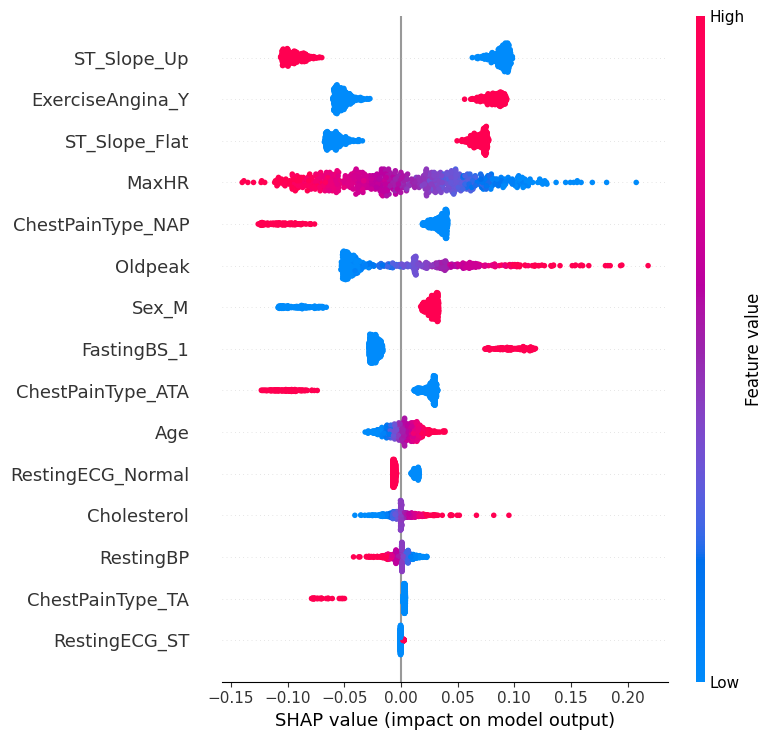

✅ wygenerowany.


In [ ]:
#    Wyświetla rozkład wpływu cech na model w skali całego zbioru
shap.summary_plot(
    shap_values_train_class_1,
    features=X_train_original,
    feature_names=X_train_original.columns,
    plot_type="dot"
)
plt.show()
print("✅ wygenerowany.")


  Można odczytać nie tylko ważność cechy, ale też **czy niska czy wysoka wartość cechy zwiększa predykcję**. Przykład:
  - Dla `ST_Slope_Up` – wysokie wartości obniżają predykcję (więcej niebieskich po prawej stronie).
  - Dla `Oldpeak` – wyższe wartości (czerwone) zwiększają prawdopodobieństwo klasy pozytywnej.


#### **Waterfall Plot**

**Co pokazuje?**  
- Prezentuje szczegółowy rozkład wpływu poszczególnych cech na predykcję dla pojedynczej obserwacji.  
- Pokazuje wartość bazową (średnia predykcja modelu) oraz, krok po kroku, jak każda cecha "popycha" wynik w górę lub w dół, aż do ostatecznej predykcji.

**Jak interpretować?**  
- **Czerwone elementy** wskazują cechy, które zwiększają wartość predykcji (wspierają daną klasę).  
- **Niebieskie elementy** wskazują cechy, które obniżają wartość predykcji.  
- Suma wszystkich efektów (dodana do wartości bazowej) daje finalną predykcję dla obserwacji.  
- Idealne narzędzie do lokalnej interpretacji – można zrozumieć, dlaczego model podjął daną decyzję dla konkretnego pacjenta.


In [ ]:
#Nowy przypadek pacjenta
new_patient = pd.DataFrame([{
    "Age": 67,
    "Sex": "M",
    "ChestPainType": "TA",
    "RestingBP": 118,
    "Cholesterol": 314,
    "FastingBS": 0,
    "RestingECG": "Normal",
    "MaxHR": 128,
    "ExerciseAngina": "Y",
    "Oldpeak": 2.5,
    "ST_Slope": "Flat"
}])

#Transformacja danych nowego pacjenta przez pipeline
new_patient_transformed = transformation_pipeline.transform(new_patient)
#pobiera nazwy cech po przetworzeniu przez Pipeline
all_features = transformation_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Odtworzenie DataFrame z nazwami kolumn
new_patient_df = pd.DataFrame(new_patient_transformed, columns=all_features, index=new_patient.index)

# Obliczenie wartości SHAP dla nowego pacjenta przy użyciu załadowanego explainera
shap_values_new_patient = explainer(new_patient_df) # lub loaded_explainer (wczytany explainer z pliku)

print(shap_values_new_patient.shape)

(1, 15, 2)


wynik shap_values_new_patient.shape to (1, 15, 2), oznacza to, że:

1 → mamy jednego pacjenta

15 → mamy 15 cech wejściowych

2 → SHAP zwraca wartości dla obu klas (0 i 1) w klasyfikacji binarnej

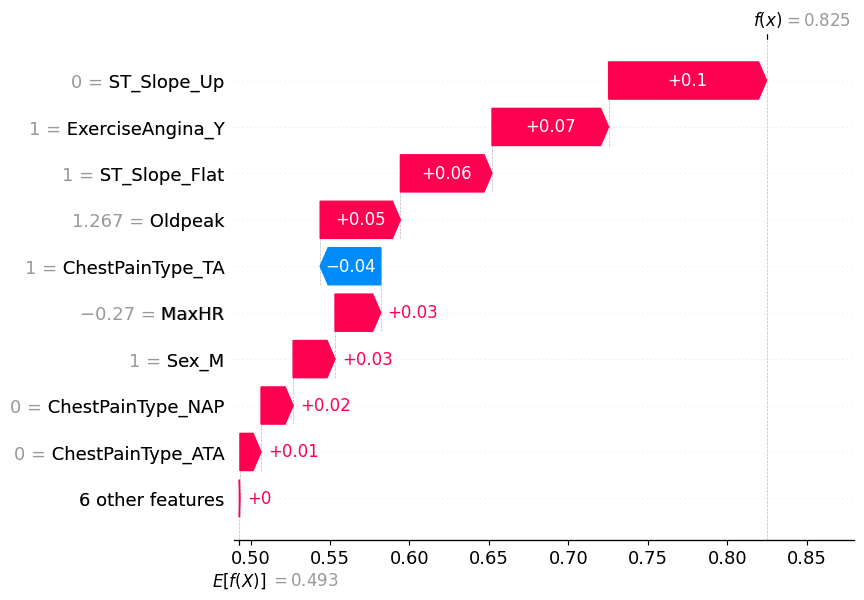

✅ Wykres SHAP dla nowego pacjenta został wygenerowany.


In [ ]:
shap_values_new_patient_class_1 = shap_values_new_patient[..., 1] # 1 oznacza klase 1 czyli HeartDisease
#Używając [..., 1], wybieram wszystkie poprzednie wymiary szystko w pierwszym wymiarze" (czyli dla jednego pacjenta) i "wszystko w drugim wymiarze" (czyli dla wszystkich 15 cech).
# Wizualizacja wykresu waterfall dla nowego pacjenta
shap.plots.waterfall(shap_values_new_patient_class_1[0]) #wybiera dane dla pierwszego pacjenta (w tym przypadku jedynego pacjenta)
plt.show()

print("✅ Wykres SHAP dla nowego pacjenta został wygenerowany.")

Pokazuje jak model doszedł do konkretnej predykcji. Dzięki czemu można zobaczyć, które cechy najbardziej „pchnęły” wynik w górę lub w dół.

### Force Plot

**Co pokazuje?**  
- Podobnie jak waterfall plot, pokazuje wpływ poszczególnych cech na predykcję pojedynczej obserwacji, ale w formie interaktywnej.  
- Umożliwia dynamiczne eksplorowanie, przy najechaniu kursorem myszki na poszczególne elementy wykresu, co pozwala na dokładniejsze poznanie wkładu poszczególnych cech.

**Jak interpretować?**  
- Interaktywny widżet pozwala zobaczyć, które cechy mają największy wpływ oraz w jaki sposób przyczyniają się do wyniku.  
- Pozwala łatwo porównać efekty cech – te, które "popychają" wynik wyżej, są widoczne po jednej stronie, a te, które go obniżają – po drugiej.


In [ ]:
# Jeśli chcesz włączyć interaktywny force_plot w Jupyterze
shap.initjs()

# 1) FORCE PLOT (lokalnie) dla tego samego pacjenta
#    - bardziej "interaktywny" widok w notatniku
force_plot_html = shap.force_plot(
    base_value   = shap_values_new_patient_class_1[0].base_values,
    shap_values  = shap_values_new_patient_class_1[0].values,
    features     = new_patient_df.iloc[0, :],
    feature_names= new_patient_df.columns
)
display(force_plot_html)  # w Jupyterze wyświetli interaktywny widżet
print("✅ Force plot (interaktywny) dla nowego pacjenta wygenerowany.")


✅ Force plot (interaktywny) dla nowego pacjenta wygenerowany.


Podobnie jak shap.waterfallplot pokazuje Pokazuje jak model doszedł do konkretnej predykcji.

### **Dependence Plot**

**Co pokazuje?**  
- Wykres zależności ilustruje, jak wartość danej cechy (umieszczona na osi X) wpływa na wartość SHAP, czyli na wkład tej cechy w predykcję modelu.  
- Punkty na wykresie reprezentują pojedyncze obserwacje ze zbioru danych, a ich pozycja na osi Y odpowiada wartości SHAP dla danej cechy.  
- Dodatkowo, kolory punktów odzwierciedlają wartości innej cechy (np. „Age”), co pozwala zobaczyć, czy i w jaki sposób interakcja między tymi dwiema cechami wpływa na wynik modelu.

**Jak interpretować?**  
- **Oś X (główna cecha):** przedstawia konkretne wartości cechy.  
- **Oś Y (wartość SHAP):** pokazuje, o ile dana cecha przesuwa predykcję modelu w górę lub w dół względem wartości bazowej.  
- **Kolor punktów:** umożliwia rozróżnienie, jak druga cecha (np. „Age”) modyfikuje wpływ głównej cechy – możesz zaobserwować, czy dla starszych pacjentów wpływ ciśnienia na wynik jest silniejszy lub słabszy niż dla młodszych.  
- **Trend:** Jeżeli widać, że wraz ze wzrostem wartości cechy na osi X wartości SHAP systematycznie rosną (lub maleją), można wnioskować, że cecha ta ma znaczący, monotoniczny wpływ na decyzję modelu.  
- **Rozproszenie:** Jeśli dla podobnych wartości cechy X wartości SHAP są bardzo rozproszone, sugeruje to, że dodatkowa cecha (reprezentowana przez kolor) ma silny wpływ – czyli interakcja między cechami odgrywa ważną rolę.


In [ ]:
print("shap_values_train shape:", shap_values_train.values.shape)
# np. (1000, 2, 13)


shap_values_train shape: (642, 15, 2)


In [ ]:
shap_values_train_class_1 = shap_values_train.values[:, :, 1]
# teraz shap_values_train_class_1.shape -> (1000, 13)
print("shap_values_train_class_1 shape:", shap_values_train_class_1.shape)

shap_values_train_class_1 shape: (642, 15)


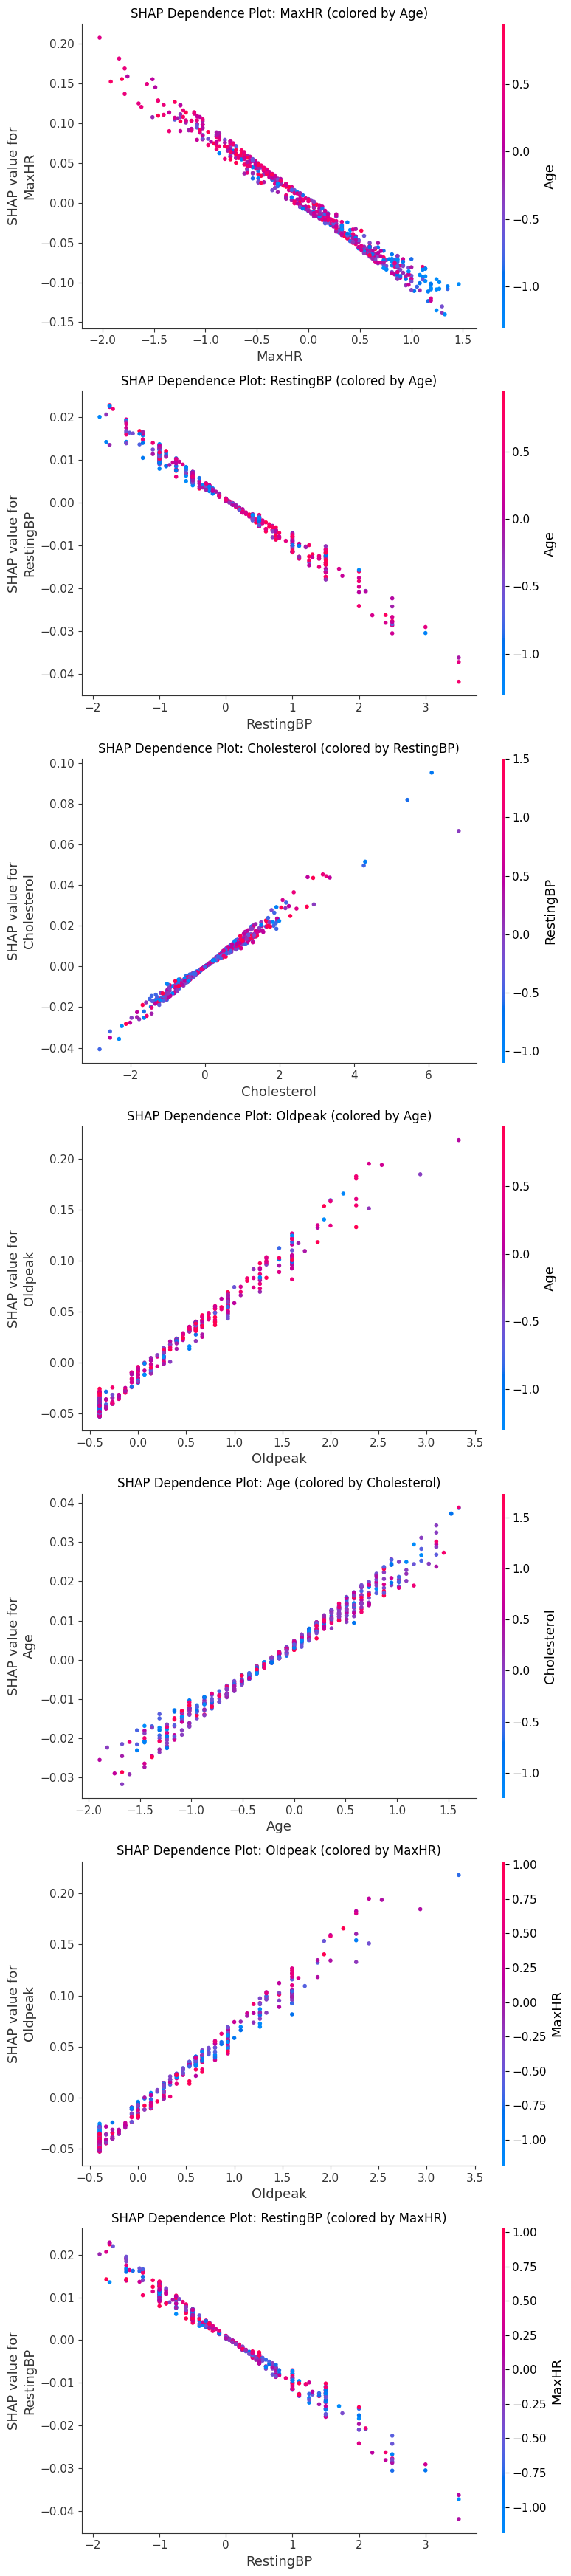

In [ ]:
import shap
import matplotlib.pyplot as plt

shap_values_train_class_1 = shap_values_train.values[:, :, 1]  # (642, 15)

combos = [
    ("MaxHR", "Age"),
    ("RestingBP", "Age"),
    ("Cholesterol", "RestingBP"),
    ("Oldpeak", "Age"),
    ("Age", "Cholesterol"),
    ("Oldpeak", "MaxHR"),
    ("RestingBP", "MaxHR")
]

# Tworzymy jedną figurę z tyloma wierszami, ile mamy par w combos
fig, axes = plt.subplots(nrows=len(combos), ncols=1, figsize=(8, 5 * len(combos)))

# Jeżeli jest tylko jeden wykres, axes będzie obiektem typu Axes, a nie listą
# dlatego poniżej ustandaryzujemy użycie listy (w przypadku 1-elementowym).
if len(combos) == 1:
    axes = [axes]

for i, (feature_main, feature_color) in enumerate(combos):
    shap.dependence_plot(
        feature_main,
        shap_values_train_class_1,     # (n_samples, n_features)
        features=X_train_original,     # DataFrame z kolumnami
        interaction_index=feature_color,
        show=False,                    # Wyłączamy automatyczne wyświetlanie
        ax=axes[i]                     # Rysujemy w wybranym pod-wykresie
    )
    axes[i].set_title(f"SHAP Dependence Plot: {feature_main} (colored by {feature_color})")

plt.tight_layout()
plt.show()

### Wnioski dla każdego wykresu **SHAP Dependence Plot**:

---

### 1.**MaxHR (kolor: Age)**  
*    Wraz ze wzrostem wartości `MaxHR`, wartość SHAP systematycznie maleje, co
oznacza, że wyższe tętno maksymalne obniża przewidywane ryzyko (pozytywną predykcję).  
*    Wiek wpływa na siłę tego efektu — młodsze osoby (niebieskie punkty) z wysokim `MaxHR` mają jeszcze mniejsze wartości SHAP niż osoby starsze, co sugeruje znaczącą interakcję między tymi cechami.

---

### 2. **RestingBP (kolor: Age)**  
*    Brak wyraźnej zależności liniowej między wartością `RestingBP` a wpływem na predykcję modelu — punkty są rozproszone blisko zera.  
*    Można zauważyć nieznaczną tendencję do wzrostu SHAP dla wyższych wartości ciśnienia, zwłaszcza u starszych osób (kolor czerwony), ale ogólnie wpływ tej cechy jest niewielki.

---

### 3. **Cholesterol (kolor: RestingBP)**  
*    Wpływ cholesterolu na predykcję jest zróżnicowany — zarówno wysokie, jak i niskie wartości mogą mieć dodatni lub ujemny wpływ, zależnie od kontekstu.  
*    Kolorowanie przez `RestingBP` sugeruje, że interakcja tych dwóch cech nie jest jednoznaczna — nie ma wyraźnego wzorca zależności.

---

### 4. **Oldpeak (kolor: Age)**  
*    Wartość `Oldpeak` ma silny dodatni wpływ na predykcję — im wyższy `Oldpeak`, tym większa wartość SHAP, co zwiększa ryzyko choroby.  
*    Efekt ten jest spójny niezależnie od wieku, co sugeruje, że `Oldpeak` działa jako silna i samodzielna cecha predykcyjna.

---

### 5. **Age (kolor: Cholesterol)**  
*    Zależność między wiekiem a wartością SHAP jest nieliniowa — największy wpływ na wzrost predykcji występuje w średnich wartościach wieku.  
*    Wysoki cholesterol (czerwony kolor) w połączeniu z wyższym wiekiem zwiększa ryzyko, co wskazuje na wyraźną interakcję między `Age` i `Cholesterol`.

---


#### **Wnioski końcowe**
Wykresy zapewniają kompleksową interpretację modelu – od szczegółowej analizy pojedynczych przypadków po globalną ocenę wpływu cech na działanie modelu. Dzięki nim możesz zarówno zidentyfikować kluczowe cechy, jak i zrozumieć, w jaki sposób poszczególne wartości wpływają na ostateczną predykcję.

# **Podsumowanie Projektu Predykcji Choroby Serca**

Projekt stanowi zintegrowane podejście do predykcji choroby serca na podstawie danych klinicznych. W pierwszej fazie przeprowadzono eksplorację danych, podczas której zidentyfikowano kluczowe cechy, takie jak wiek, ciśnienie spoczynkowe, poziom cholesterolu, maksymalne tętno oraz wskaźnik Oldpeak. Analiza statystyczna i wizualizacja rozkładów pozwoliły lepiej zrozumieć strukturę danych oraz wykryć potencjalne błędy pomiarowe.

Dane zostały następnie przygotowane poprzez czyszczenie, skalowanie (Robust Scaler) i kodowanie one-hot, a cały proces zautomatyzowano za pomocą pipeline’u w scikit-learn. Kolejny etap obejmował budowę i ocenę modeli klasyfikacyjnych (m.in. SVM, regresja logistyczna, KNN, drzewo decyzyjne, Random Forest oraz metody ensemble), z których model SVM został wybrany jako najlepszy na podstawie metryk Accuracy, F1-score i AUC-ROC.

Aby zwiększyć interpretowalność wyników, zastosowano narzędzie SHAP, umożliwiające analizę wpływu poszczególnych cech na decyzje modelu. Wykorzystano wizualizacje SHAP, takie jak summary plot, dependence plot oraz waterfall plot, co pozwoliło na dogłębną analizę mechanizmu działania modelu. Projekt ten pokazuje, jak kompleksowe podejście do analizy danych i uczenia maszynowego może skutecznie identyfikować pacjentów zagrożonych chorobą serca, zwiększając jednocześnie transparentność procesu decyzyjnego.